In [1]:
import os 
import json
import pandas as pd
import numpy as np

In [23]:
user_items_df = pd.read_csv('/Users/vince/Salk/mCC_Analysis/data/compliant_user_items.csv')

# Load JSON file containing food corrections
with open('/Users/vince/Salk/mCC_Analysis/food_corrections.json', 'r') as f:
    food_corrections = json.load(f)

# Create a new column with corrected food names
user_items_df['corrected_food'] = user_items_df['parsing_result'].map(food_corrections).str.lower()

In [2]:
import pickle 

with open('food_embeddings.pkl', 'rb') as f:
    food_embeddings = pickle.load(f)

In [4]:
food_df = pd.read_csv("food_df.csv", index_col=0)

In [17]:
food_df

,food_type,parsing_result,corrected_food,food_cluster,food_name_safe,food_embedding
0,b,nespresso,nespresso,13,nespresso,[ 3.01805420e-02 2.88329010e-02 -6.66379300e-...
1,f,oatmeal,oatmeal,70,oatmeal,[ 3.40316970e-02 4.60686000e-02 -3.08820880e-...
2,b,milk,milk,34,milk,[ 4.53863440e-02 1.91603790e-02 -5.22305370e-...
3,f,eggplant,eggplant,24,eggplant,[ 7.60755460e-03 -1.13470300e-02 -6.46341200e-...
4,f,lasagna,lasagna,45,lasagna,[ 1.77221450e-02 5.09285000e-03 -3.14315930e-...
...,...,...,...,...,...,...
2752,b,asahi vegan beer,asahi vegan beer,75,asahi_vegan_beer,[ 3.59883830e-02 4.74282900e-02 -6.40541540e-...
2753,f,eye round roast,eye of round roast,81,eye_of_round_roast,[ 4.94876430e-02 3.65882370e-02 -3.47454060e-...
2754,f,whey hydro isolate zero,whey hydrolysate isolate zero,65,whey_hydrolysate_isolate_zero,[ 4.68241240e-02 1.40685250e-02 -6.96792000e-...
2755,f,barukas,barukas,56,barukas,[ 3.69833900e-03 3.79980730e-02 -2.07108400e-...


In [6]:
# Load food_cluster_summaries.pkl
with open('food_cluster_summaries.pkl', 'rb') as f:
    food_cluster_summaries = pickle.load(f)

In [18]:
# Create a mapping DataFrame from the cluster summaries dictionary
cluster_mapping = pd.DataFrame([
    {
        'food_cluster': summary['cluster_id'], 
        'cluster_representative': summary['primary_representative'],
        'cluster_description': summary['description'].split('\n')[0]  # Just the first line of the description
    } 
    for cluster_id, summary in food_cluster_summaries.items()
])

# Make sure the cluster ID column is the same data type as in food_df (likely int)
cluster_mapping['food_cluster'] = cluster_mapping['food_cluster'].astype(int)

# Merge with food_df to add the representative label
food_df_with_labels = food_df.merge(
    cluster_mapping[['food_cluster', 'cluster_representative', 'cluster_description']], 
    on='food_cluster', 
    how='left'
)

# Handle foods that were not mapped to any cluster (food_cluster = -1)
food_df_with_labels.loc[food_df_with_labels['food_cluster'] == -1, 'cluster_representative'] = 'uncategorized'
food_df_with_labels.loc[food_df_with_labels['food_cluster'] == -1, 'cluster_description'] = 'Uncategorized food item'

# Now, if you want to see distribution of items by cluster
cluster_distribution = food_df_with_labels.groupby(['food_cluster', 'cluster_representative']).size().reset_index(name='count')
cluster_distribution = cluster_distribution.sort_values('count', ascending=False)

print(f"Food items assigned to {len(cluster_mapping)} clusters")
print("\nTop 10 food clusters by item count:")
print(cluster_distribution.head(10))

Food items assigned to 100 clusters

Top 10 food clusters by item count:
    food_cluster cluster_representative  count
10            10                  bread     52
3              3                larabar     50
13            13                 coffee     49
1              1                 cheese     48
70            70                oatmeal     47
22            22                 salmon     47
5              5                    gin     45
2              2                 cookie     43
6              6                   soda     43
4              4                  bacon     42


In [19]:
food_df_with_labels[['corrected_food', 'food_cluster', 'cluster_representative']]

,corrected_food,food_cluster,cluster_representative
0,nespresso,13,coffee
1,oatmeal,70,oatmeal
2,milk,34,milk
3,eggplant,24,soup
4,lasagna,45,lasagna
...,...,...,...
2752,asahi vegan beer,75,beer
2753,eye of round roast,81,steak
2754,whey hydrolysate isolate zero,65,shake
2755,barukas,56,almond


In [24]:
user_items_df

,pid,compliance_days_passed,food_type,original_logtime,log_date,time,compliance_date,parsing_result,corrected_food
0,alqt150211047,0,b,2021-10-28 09:45:59,2021-10-28,9.766389,2021-10-28,nespresso,nespresso
1,alqt150211047,0,f,2021-10-28 09:45:59,2021-10-28,9.766389,2021-10-28,oatmeal,oatmeal
2,alqt150211047,0,b,2021-10-28 09:45:59,2021-10-28,9.766389,2021-10-28,milk,milk
3,alqt150211047,0,f,2021-10-28 11:57:00,2021-10-28,11.950000,2021-10-28,eggplant,eggplant
4,alqt150211047,0,f,2021-10-28 11:57:00,2021-10-28,11.950000,2021-10-28,lasagna,lasagna
...,...,...,...,...,...,...,...,...,...
3184274,alqt230941256543,13,b,2023-09-21 16:32:00,2023-09-21,16.533333,2023-09-21,hibiscus tea,hibiscus tea
3184275,alqt230941256543,13,f,2023-09-21 16:32:00,2023-09-21,16.533333,2023-09-21,blueberry,blueberry
3184276,alqt230941256543,13,f,2023-09-21 19:25:00,2023-09-21,19.416667,2023-09-21,baked chicken,baked chicken
3184277,alqt230941256543,13,f,2023-09-21 19:25:00,2023-09-21,19.416667,2023-09-21,mashed potato,mashed potato


In [26]:
user_items_df = user_items_df.merge(food_df_with_labels[['corrected_food', 'food_cluster', 'cluster_representative']])

In [27]:
# user_items_df['embedding'] = user_items_df['food_item'].map(food_embeddings.set_index('food_item')['embedding'].to_dict())
user_items_df = user_items_df.drop(columns=['compliance_days_passed', 'compliance_date', 'parsing_result'])
user_items_df = user_items_df.rename(columns={'corrected_food': 'food_item', 'time': 'time_24h_decimal'})
user_items_df

,pid,food_type,original_logtime,log_date,time_24h_decimal,food_item,food_cluster,cluster_representative
0,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,nespresso,13,coffee
1,alqt150211047,f,2021-10-28 09:45:59,2021-10-28,9.766389,oatmeal,70,oatmeal
2,alqt150211047,f,2021-10-28 09:45:59,2021-10-28,9.766389,oatmeal,70,oatmeal
3,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,milk,34,milk
4,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,milk,34,milk
...,...,...,...,...,...,...,...,...
4240271,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,baked chicken,35,chicken
4240272,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,mashed potato,67,potato
4240273,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,salad,43,salad
4240274,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,salad,43,salad


In [28]:
# Process food timing data
def add_meal_timing_features(food_df):
    # Define time ranges for different meal types
    food_df['is_breakfast'] = (food_df['time_24h_decimal'] >= 6) & (food_df['time_24h_decimal'] < 10)
    food_df['is_lunch'] = (food_df['time_24h_decimal'] >= 11) & (food_df['time_24h_decimal'] < 14)
    food_df['is_dinner'] = (food_df['time_24h_decimal'] >= 17) & (food_df['time_24h_decimal'] < 21)
    food_df['is_late_night'] = (food_df['time_24h_decimal'] >= 21) | (food_df['time_24h_decimal'] < 4)
    
    # More nuanced time divisions if needed
    food_df['time_period'] = pd.cut(
        food_df['time_24h_decimal'] % 24, 
        bins=[0, 6, 10, 14, 18, 22, 24],
        labels=['night', 'morning', 'midday', 'afternoon', 'evening', 'night'],
        include_lowest=True,
        ordered=False
    )
    
    return food_df

# Process the food dataframe
user_items_enhanced = add_meal_timing_features(user_items_df)

In [29]:
user_items_enhanced['time_period'].value_counts()

time_period
midday       1277428
evening      1010668
afternoon     924092
morning       866449
night         161639
Name: count, dtype: int64

In [30]:
user_items_enhanced

,pid,food_type,original_logtime,log_date,time_24h_decimal,food_item,food_cluster,cluster_representative,is_breakfast,is_lunch,is_dinner,is_late_night,time_period
0,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,nespresso,13,coffee,True,False,False,False,morning
1,alqt150211047,f,2021-10-28 09:45:59,2021-10-28,9.766389,oatmeal,70,oatmeal,True,False,False,False,morning
2,alqt150211047,f,2021-10-28 09:45:59,2021-10-28,9.766389,oatmeal,70,oatmeal,True,False,False,False,morning
3,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,milk,34,milk,True,False,False,False,morning
4,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,milk,34,milk,True,False,False,False,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240271,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,baked chicken,35,chicken,False,False,True,False,evening
4240272,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,mashed potato,67,potato,False,False,True,False,evening
4240273,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,salad,43,salad,False,False,True,False,evening
4240274,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,salad,43,salad,False,False,True,False,evening


## Sleep Data

In [31]:
user_sleep_df = pd.read_csv('/Users/vince/Salk/mCC_Analysis/data/compliant_user_sleep.csv')
user_sleep_df.drop(columns=['Unnamed: 0'], inplace=True)
print(user_sleep_df.shape)

(753776, 10)


In [32]:
# Group by pid and measured_date and count the number of entries
sleep_entry_counts = user_sleep_df.groupby(['pid', 'measured_date']).size().reset_index(name='entry_count')

# View the result
print(sleep_entry_counts.head())

# To see the distribution of entry counts
print(sleep_entry_counts['entry_count'].value_counts())

# To find users with multiple entries on the same day
multiple_entries = sleep_entry_counts[sleep_entry_counts['entry_count'] > 1]
print(f"Number of instances with multiple entries: {len(multiple_entries)}")

             pid measured_date  entry_count
0  alqt150211047    2021-10-02            1
1  alqt150211047    2021-10-28            1
2  alqt150211047    2021-10-29            1
3  alqt150211047    2021-10-30            1
4  alqt150211047    2021-10-31            1
entry_count
1    660173
2     39363
3      4291
4       439
5        31
7         5
6         4
9         2
8         2
Name: count, dtype: int64
Number of instances with multiple entries: 44137


### Sleep Filtering

In [33]:
user_sleep_df = user_sleep_df[(user_sleep_df['sleep_duration_decimal'] > 2) & 
                                 (user_sleep_df['sleep_duration_decimal'] < 14)]

In [34]:
duplicate_cols = ['pid', 'measured_date', 'sleep_time', 'wakeup_time', 'sleep_duration']
duplicate_mask = user_sleep_df.duplicated(subset=duplicate_cols, keep='last')
user_sleep_df_deduped = user_sleep_df[~duplicate_mask]
user_sleep_df_deduped.shape

(714645, 10)

In [35]:
from datetime import datetime, timedelta

clean_data = []

# for (pid, date), group in user_sleep_df_deduped.groupby(['pid', 'measured_date']):
#     if len(group) == 1:
#         # Only one entry, keep it
#         clean_data.append(group)
#     else:
#         # Convert times to datetime objects for comparison
#         group = group.copy()
        
#         # Handle time that crosses midnight (e.g., 23:00 to 06:00)
#         def create_datetime(row, time_col):
#             time_obj = datetime.strptime(str(row[time_col]), '%H:%M:%S').time()
#             date_obj = datetime.strptime(str(row['measured_date']), '%Y-%m-%d').date()
            
#             # If wakeup_time is earlier than sleep_time, it's the next day
#             if time_col == 'wakeup_time' and time_obj < datetime.strptime(str(row['sleep_time']), '%H:%M:%S').time():
#                 next_day = date_obj + timedelta(days=1)
#                 return datetime.combine(next_day, time_obj)
#             return datetime.combine(date_obj, time_obj)
        
#         # Add datetime versions of sleep and wakeup times
#         group['sleep_datetime'] = group.apply(lambda row: create_datetime(row, 'sleep_time'), axis=1)
#         group['wakeup_datetime'] = group.apply(lambda row: create_datetime(row, 'wakeup_time'), axis=1)
        
#         # Sort by sleep_datetime to process from earliest to latest
#         group = group.sort_values('sleep_datetime')
        
#         # If you simply want to keep the last entry:
#         last_entry = group.iloc[[-1]]
#         clean_data.append(last_entry)

for (pid, date), group in user_sleep_df_deduped.groupby(['pid', 'measured_date']):
    if len(group) == 1:
        # Only one entry, keep it
        clean_data.append(group)
    else:
        # Simply keep the row with the highest index
        # This assumes that the index represents the order of entry
        last_entry = group.iloc[[group.index.argmax()]]
        clean_data.append(last_entry)

# Combine the results
cleaned_sleep_df = pd.concat(clean_data)

# Step 4: Apply your duration filter
final_sleep_df = cleaned_sleep_df[(cleaned_sleep_df['sleep_duration_decimal'] > 3) & 
                                 (cleaned_sleep_df['sleep_duration_decimal'] < 16)]

# Show the results
print(f"Original shape: {user_sleep_df.shape}")
print(f"After deduplication: {user_sleep_df_deduped.shape}")
print(f"After resolving overlaps: {cleaned_sleep_df.shape}")
print(f"After duration filtering: {final_sleep_df.shape}")

Original shape: (722794, 10)
After deduplication: (714645, 10)
After resolving overlaps: (690632, 10)
After duration filtering: (687146, 10)


In [36]:
user_sleep_df = final_sleep_df

In [37]:
user_sleep_df['enough_sleep'].value_counts()

enough_sleep
False    534304
True     152842
Name: count, dtype: int64

In [38]:
user_sleep_df['sleep_problems'].value_counts()[:20]

sleep_problems
--- ''\n                                                                            235022
---\n- 'null'\n                                                                     121196
---\n- Woke up once or more\n                                                        27431
---\n- Insufficient sleep\n                                                          22860
---\n- Woke up once or more\n- Insufficient sleep\n                                  10060
Woke up once or more                                                                  8659
Insufficient sleep                                                                    6703
---\n- Difficult falling asleep\n- Woke up once or more\n- Insufficient sleep\n       3828
--- \n...\n                                                                           3762
---\n- Difficulty falling asleep\n- Woke up once or more\n- Insufficient sleep\n      3268
---\n- Difficult falling asleep\n- Woke up once or more\n                  

In [39]:
sleep_null = ["---\n- 'null'\n", "--- ''\n"]
user_sleep_df.loc[user_sleep_df['sleep_problems'].isin(sleep_null), 'sleep_problems'] = None

In [40]:
user_sleep_df['sleep_problems'].value_counts()

sleep_problems
---\n- Woke up once or more\n                                                 27431
---\n- Insufficient sleep\n                                                   22860
---\n- Woke up once or more\n- Insufficient sleep\n                           10060
Woke up once or more                                                           8659
Insufficient sleep                                                             6703
                                                                              ...  
---\n- Woke up once or more\n- hit snooze button till 8h30\n                      1
---\n- Woke up once or more\n- Difficult falling asleep\n- freezing cold\n        1
---\n- period\n                                                                   1
---\n- Insufficient sleep\n- totally drained of energy\n                          1
Woke up once or more,knee pain post surgery                                       1
Name: count, Length: 29736, dtype: int64

In [41]:
user_sleep_df['sleep_problems_bool'] = ~user_sleep_df['sleep_problems'].isna()

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_43703/490070420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_sleep_df['sleep_problems_bool'] = ~user_sleep_df['sleep_problems'].isna()


In [42]:
user_sleep_df = user_sleep_df[['pid', 'measured_date',
       'enough_sleep', 'sleep_problems_bool', 'sleep_time_decimal',
       'sleep_duration_decimal', 'wakeup_time_decimal']]

In [43]:
user_sleep_df

,pid,measured_date,enough_sleep,sleep_problems_bool,sleep_time_decimal,sleep_duration_decimal,wakeup_time_decimal
182239,alqt150211047,2021-10-02,False,True,22.583333,7.916667,6.500000
182240,alqt150211047,2021-10-28,False,True,23.166667,8.966667,8.133333
182241,alqt150211047,2021-10-29,True,False,23.500000,9.500000,9.000000
182242,alqt150211047,2021-10-30,False,True,22.333333,8.916667,7.250000
182243,alqt150211047,2021-10-31,True,False,22.500000,9.050000,7.550000
...,...,...,...,...,...,...,...
743962,alqt230941256543,2023-09-26,False,True,22.500000,8.416667,6.916667
744053,alqt230941256543,2023-09-27,False,True,2.250000,5.250000,7.500000
744130,alqt230941256543,2023-09-28,False,True,0.166667,8.333333,8.500000
744162,alqt230941256543,2023-09-29,False,True,22.500000,6.566667,5.066667


In [45]:
user_sleep_df[['enough_sleep', 'sleep_problems_bool']].value_counts()

enough_sleep  sleep_problems_bool
False         False                  375350
              True                   158954
True          False                  147188
              True                     5654
Name: count, dtype: int64

In [44]:
user_sleep_df[user_sleep_df['enough_sleep']]['sleep_duration_decimal'].describe()

count    152842.000000
mean          7.816135
std           1.179256
min           3.016667
25%           7.050000
50%           7.866667
75%           8.500000
max          13.966667
Name: sleep_duration_decimal, dtype: float64

In [ ]:
user_sleep_df.to_csv('user_sleep_df.csv', index=False)

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

# Step 1: Create sleep archetypes with one-hot encoding
def create_sleep_archetypes(df):
    # Make a copy to avoid modifying the original
    result = df.copy()
    
    # Sleep time archetypes
    result['early_sleeper'] = (result['sleep_time_decimal'] >= 19) & (result['sleep_time_decimal'] < 22)
    result['normal_sleeper'] = (result['sleep_time_decimal'] >= 22) & (result['sleep_time_decimal'] < 24)
    result['late_sleeper'] = (result['sleep_time_decimal'] >= 24) | (result['sleep_time_decimal'] < 3)
    result['irregular_sleeper'] = (result['sleep_time_decimal'] >= 3) & (result['sleep_time_decimal'] < 19)
    
    # Sleep duration archetypes
    result['short_sleep'] = result['sleep_duration_decimal'] < 6
    result['normal_sleep'] = (result['sleep_duration_decimal'] >= 6) & (result['sleep_duration_decimal'] < 9)
    result['long_sleep'] = result['sleep_duration_decimal'] >= 9
    
    # Wake time archetypes
    result['early_riser'] = (result['wakeup_time_decimal'] >= 3) & (result['wakeup_time_decimal'] < 7)
    result['normal_riser'] = (result['wakeup_time_decimal'] >= 7) & (result['wakeup_time_decimal'] < 9)
    result['late_riser'] = (result['wakeup_time_decimal'] >= 9) | (result['wakeup_time_decimal'] < 3)
    
    # Keep the cyclical encoding for time values
    result['sleep_time_sin'] = np.sin(result['sleep_time_decimal'] * 2 * np.pi / 24)
    result['sleep_time_cos'] = np.cos(result['sleep_time_decimal'] * 2 * np.pi / 24)
    result['wakeup_time_sin'] = np.sin(result['wakeup_time_decimal'] * 2 * np.pi / 24)
    result['wakeup_time_cos'] = np.cos(result['wakeup_time_decimal'] * 2 * np.pi / 24)
    
    # Add quality indicators
    result['satisfied'] = result['enough_sleep']
    result['has_problems'] = result['sleep_problems_bool']
    
    return result

# Create the augmented dataframe
sleep_augmented = create_sleep_archetypes(user_sleep_df)


# Step 2: Prepare features for clustering
feature_columns = [
    'early_sleeper', 'normal_sleeper', 'late_sleeper', 'irregular_sleeper',
    'short_sleep', 'normal_sleep', 'long_sleep',
    'early_riser', 'normal_riser', 'late_riser',
    'sleep_time_sin', 'sleep_time_cos', 'wakeup_time_sin', 'wakeup_time_cos',
    'sleep_duration_decimal', 'satisfied', 'has_problems'
]

# Select features
features = sleep_augmented[feature_columns].copy()

# Step 3: Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [48]:
sleep_augmented

,pid,measured_date,enough_sleep,sleep_problems_bool,sleep_time_decimal,sleep_duration_decimal,wakeup_time_decimal,early_sleeper,normal_sleeper,late_sleeper,...,long_sleep,early_riser,normal_riser,late_riser,sleep_time_sin,sleep_time_cos,wakeup_time_sin,wakeup_time_cos,satisfied,has_problems
182239,alqt150211047,2021-10-02,False,True,22.583333,7.916667,6.500000,False,True,False,...,False,True,False,False,-0.362438,0.932008,0.991445,-0.130526,False,True
182240,alqt150211047,2021-10-28,False,True,23.166667,8.966667,8.133333,False,True,False,...,False,False,True,False,-0.216440,0.976296,0.848048,-0.529919,False,True
182241,alqt150211047,2021-10-29,True,False,23.500000,9.500000,9.000000,False,True,False,...,True,False,False,True,-0.130526,0.991445,0.707107,-0.707107,True,False
182242,alqt150211047,2021-10-30,False,True,22.333333,8.916667,7.250000,False,True,False,...,False,False,True,False,-0.422618,0.906308,0.946930,-0.321439,False,True
182243,alqt150211047,2021-10-31,True,False,22.500000,9.050000,7.550000,False,True,False,...,True,False,True,False,-0.382683,0.923880,0.918791,-0.394744,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743962,alqt230941256543,2023-09-26,False,True,22.500000,8.416667,6.916667,False,True,False,...,False,True,False,False,-0.382683,0.923880,0.971342,-0.237686,False,True
744053,alqt230941256543,2023-09-27,False,True,2.250000,5.250000,7.500000,False,False,True,...,False,False,True,False,0.555570,0.831470,0.923880,-0.382683,False,True
744130,alqt230941256543,2023-09-28,False,True,0.166667,8.333333,8.500000,False,False,True,...,False,False,True,False,0.043619,0.999048,0.793353,-0.608761,False,True
744162,alqt230941256543,2023-09-29,False,True,22.500000,6.566667,5.066667,False,True,False,...,False,True,False,False,-0.382683,0.923880,0.970296,0.241922,False,True


In [49]:


# Step 4: Apply t-SNE for visualization
# For large datasets, sample to make t-SNE more efficient
max_sample = 20000
if len(sleep_augmented) > max_sample:
    sample_indices = np.random.choice(len(sleep_augmented), max_sample, replace=False)
    sample_features = scaled_features[sample_indices]
    sample_df = sleep_augmented.iloc[sample_indices].copy()
else:
    sample_features = scaled_features
    sample_df = sleep_augmented.copy()

print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(sample_features)

# Add t-SNE coordinates to the sample dataframe
sample_df['tsne_x'] = tsne_results[:, 0]
sample_df['tsne_y'] = tsne_results[:, 1]


Running t-SNE...


/Users/vince/miniforge3/envs/ds/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


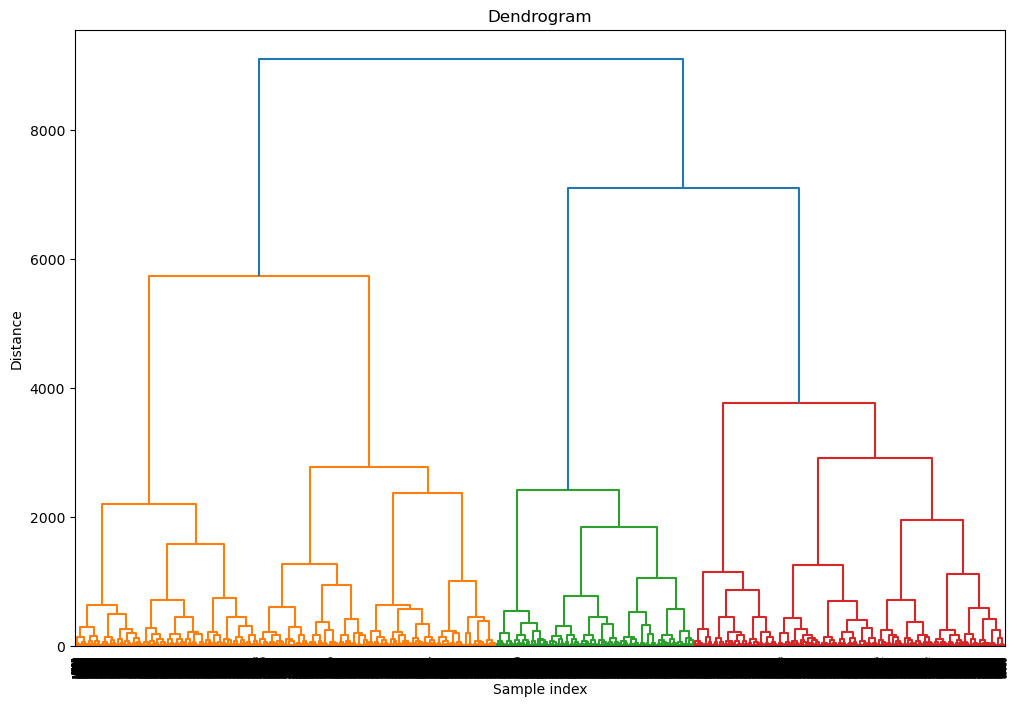

In [50]:

# Step 5: Apply hierarchical clustering on the t-SNE results
# Determine optimal number of clusters using dendrogram
plt.figure(figsize=(12, 8))
dendrogram = shc.dendrogram(shc.linkage(tsne_results, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()




In [51]:
# Based on the dendrogram, choose a reasonable number of clusters
n_clusters = 6  # Adjust based on dendrogram visualization
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
sample_df['cluster'] = hierarchical.fit_predict(tsne_results)

In [52]:
sample_df

,pid,measured_date,enough_sleep,sleep_problems_bool,sleep_time_decimal,sleep_duration_decimal,wakeup_time_decimal,early_sleeper,normal_sleeper,late_sleeper,...,late_riser,sleep_time_sin,sleep_time_cos,wakeup_time_sin,wakeup_time_cos,satisfied,has_problems,tsne_x,tsne_y,cluster
478105,alqt190383553,2019-03-22,False,False,0.000000,7.416667,7.416667,False,False,True,...,False,0.000000,1.000000,0.932008,-0.362438,False,False,-89.291580,-61.740204,2
396740,alqt180958971,2018-12-04,False,False,21.500000,8.000000,5.500000,True,False,False,...,False,-0.608761,0.793353,0.991445,0.130526,False,False,57.920162,91.563217,3
504551,alqt190691612,2019-06-11,False,False,21.766667,7.800000,5.566667,True,False,False,...,False,-0.551937,0.833886,0.993572,0.113203,False,False,72.834785,83.662827,3
39656,alqt150220129196942,2022-01-14,True,False,23.933333,7.066667,7.000000,False,True,False,...,False,-0.017452,0.999848,0.965926,-0.258819,True,False,-1.059860,18.031443,5
489917,alqt190486076,2019-04-10,False,False,0.100000,7.350000,7.450000,False,False,True,...,False,0.026177,0.999657,0.928810,-0.370557,False,False,-88.880287,-61.609692,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738533,alqt211050187340,2021-10-03,False,False,0.000000,7.333333,7.333333,False,False,True,...,False,0.000000,1.000000,0.939693,-0.342020,False,False,-88.892090,-62.895718,2
104608,alqt150220326204652,2022-09-09,True,False,22.283333,9.316667,7.600000,False,True,False,...,False,-0.434445,0.900698,0.913545,-0.406737,True,False,-21.939350,56.418503,4
447333,alqt190176481,2019-03-02,False,False,23.816667,8.266667,8.083333,False,True,False,...,False,-0.047978,0.998848,0.854912,-0.518773,False,False,-52.876865,6.118505,2
263465,alqt171118663,2018-01-31,False,False,0.316667,8.033333,8.633333,False,False,True,...,False,0.082808,0.996566,0.771625,-0.636078,False,False,-91.218384,-36.262276,2


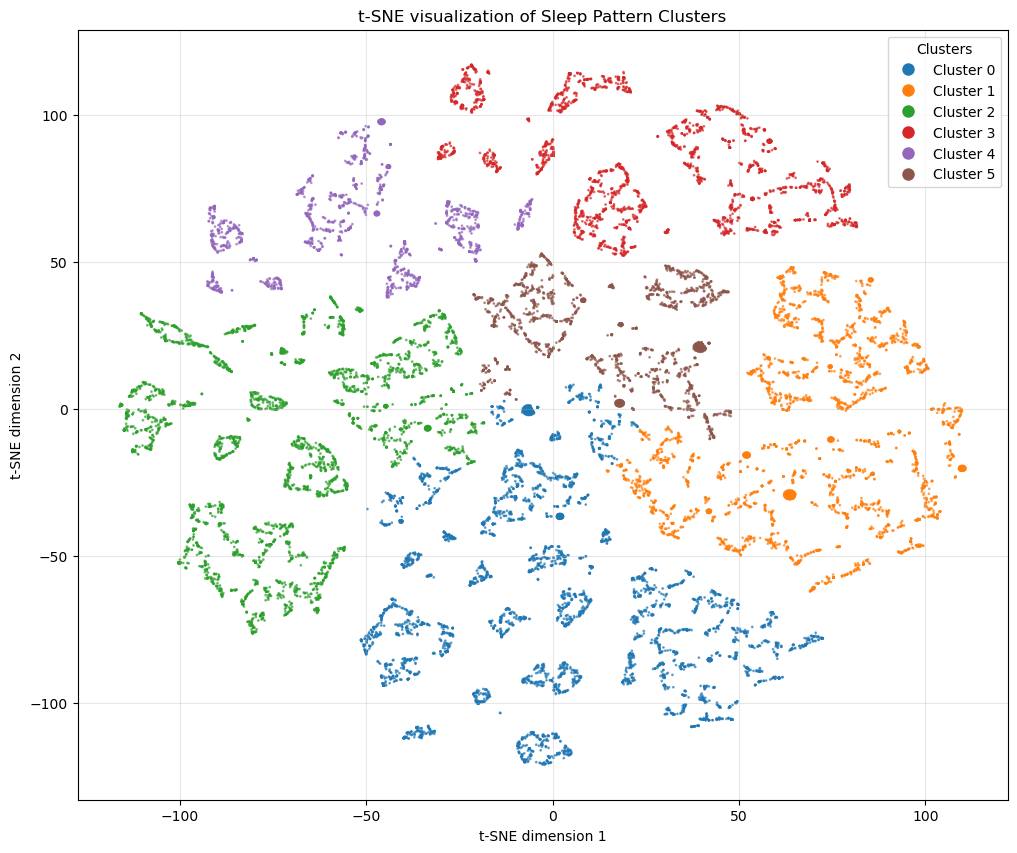

In [53]:
# Step 6: Visualize the clusters on t-SNE with a proper legend
plt.figure(figsize=(12, 10))

# Get unique clusters
unique_clusters = sorted(sample_df['cluster'].unique())

# Create a custom colormap with only the colors we need
from matplotlib.colors import ListedColormap
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Get the tab10 colors
cluster_colors = colors[unique_clusters]  # Select only colors for our clusters
custom_cmap = ListedColormap(cluster_colors)

# Create scatter plot
scatter = plt.scatter(
    sample_df['tsne_x'], 
    sample_df['tsne_y'], 
    c=sample_df['cluster'],
    cmap=custom_cmap, 
    alpha=0.6, 
    s=1
)

# Create legend with one entry per cluster
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], 
           label=f'Cluster {i}', markersize=10)
    for i in unique_clusters
]

plt.legend(handles=legend_elements, title="Clusters", loc="best")
plt.title('t-SNE visualization of Sleep Pattern Clusters')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.grid(True, alpha=0.3)
plt.show()

In [54]:

# Step 7: Analyze the characteristics of each cluster
cluster_analysis = sample_df.groupby('cluster').agg({
    'early_sleeper': 'mean',
    'normal_sleeper': 'mean',
    'late_sleeper': 'mean',
    'irregular_sleeper': 'mean',
    'short_sleep': 'mean',
    'normal_sleep': 'mean',
    'long_sleep': 'mean',
    'early_riser': 'mean',
    'normal_riser': 'mean',
    'late_riser': 'mean',
    'sleep_duration_decimal': 'mean',
    'sleep_time_decimal': 'mean',
    'wakeup_time_decimal': 'mean',
    'satisfied': 'mean',
    'has_problems': 'mean'
}).round(2)

print("\nCluster Analysis:")
display(cluster_analysis)



Cluster Analysis:


,early_sleeper,normal_sleeper,late_sleeper,irregular_sleeper,short_sleep,normal_sleep,long_sleep,early_riser,normal_riser,late_riser,sleep_duration_decimal,sleep_time_decimal,wakeup_time_decimal,satisfied,has_problems
cluster,,,,,,,,,,,,,,,
0,0.01,0.66,0.33,0.00,0.25,0.75,0.00,0.62,0.38,0.00,6.74,15.66,6.48,0.06,0.67
1,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,7.07,22.84,5.99,0.37,0.00
2,0.00,0.31,0.62,0.07,0.03,0.87,0.09,0.00,0.69,0.30,7.77,8.15,8.50,0.17,0.08
3,0.99,0.00,0.00,0.01,0.00,0.67,0.33,0.84,0.16,0.00,8.47,21.28,5.82,0.31,0.04
4,0.07,0.93,0.00,0.00,0.00,0.00,1.00,0.06,0.71,0.23,9.54,22.56,8.22,0.21,0.25
5,0.18,0.82,0.00,0.00,0.00,1.00,0.00,0.57,0.42,0.00,8.00,22.50,6.57,0.36,0.19


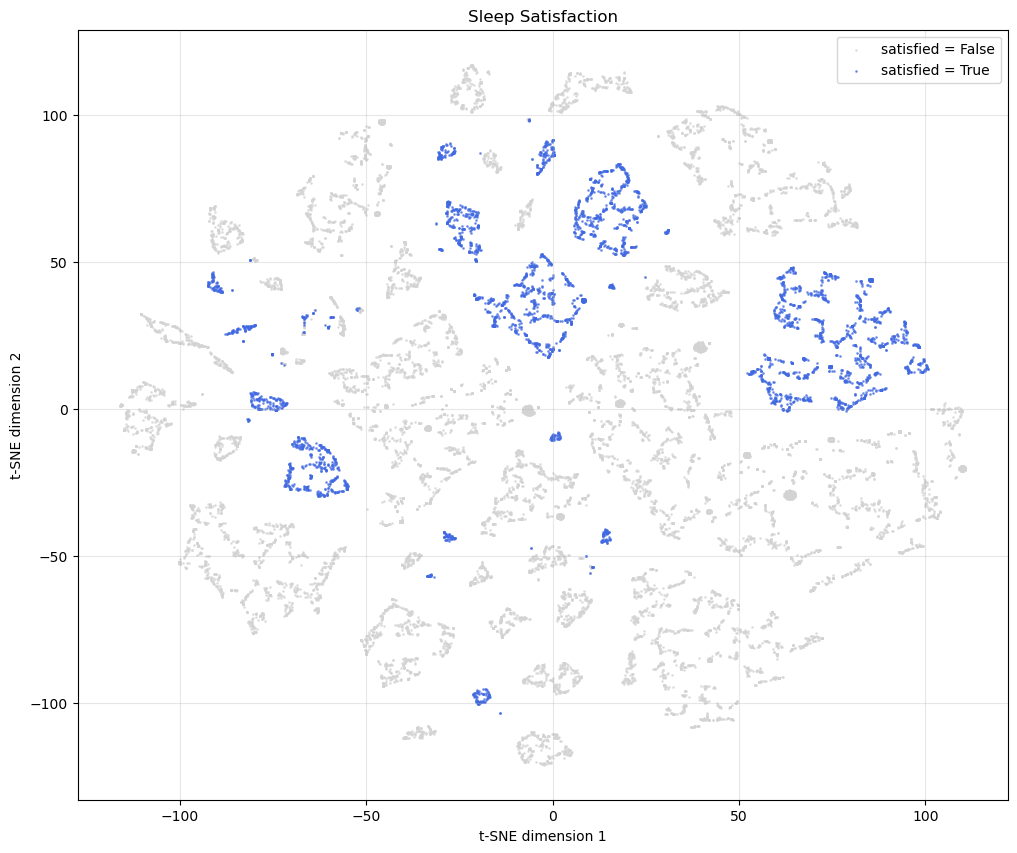

Statistics for satisfied:
True: 4475 (22.4%)
False: 15525 (77.6%)


In [55]:
def visualize_tsne_by_boolean(sample_df, boolean_column, title=None, s=1, alpha=0.6):
    """
    Visualize t-SNE results colored by a boolean column.
    
    Parameters:
    -----------
    sample_df : pandas DataFrame
        DataFrame containing 'tsne_x', 'tsne_y' columns and the boolean column
    boolean_column : str
        Name of the boolean column to use for coloring
    title : str, optional
        Plot title. If None, a default title is used.
    s : float, optional
        Marker size
    alpha : float, optional
        Transparency of the markers
    """
    # Validate the column exists and is boolean-like
    if boolean_column not in sample_df.columns:
        raise ValueError(f"Column '{boolean_column}' not found in the DataFrame")
    
    # Convert to boolean if it's not already
    is_bool = sample_df[boolean_column].map({True: True, False: False, 1: True, 0: False})
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Define colors for True and False
    true_color = 'royalblue'
    false_color = 'lightgray'
    
    # Plot False values first (as background)
    plt.scatter(
        sample_df.loc[~is_bool, 'tsne_x'],
        sample_df.loc[~is_bool, 'tsne_y'],
        color=false_color,
        alpha=alpha,
        s=s,
        label=f"{boolean_column} = False"
    )
    
    # Plot True values on top
    plt.scatter(
        sample_df.loc[is_bool, 'tsne_x'],
        sample_df.loc[is_bool, 'tsne_y'],
        color=true_color,
        alpha=alpha,
        s=s,
        label=f"{boolean_column} = True"
    )
    
    # Set title
    if title is None:
        title = f't-SNE Visualization by {boolean_column}'
    plt.title(title)
    
    # Add labels and legend
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Show plot
    plt.show()
    
    # Print some statistics
    true_count = is_bool.sum()
    false_count = (~is_bool).sum()
    total = len(is_bool)
    
    print(f"Statistics for {boolean_column}:")
    print(f"True: {true_count} ({true_count/total:.1%})")
    print(f"False: {false_count} ({false_count/total:.1%})")

# Example usage:
visualize_tsne_by_boolean(sample_df, 'satisfied', title='Sleep Satisfaction')


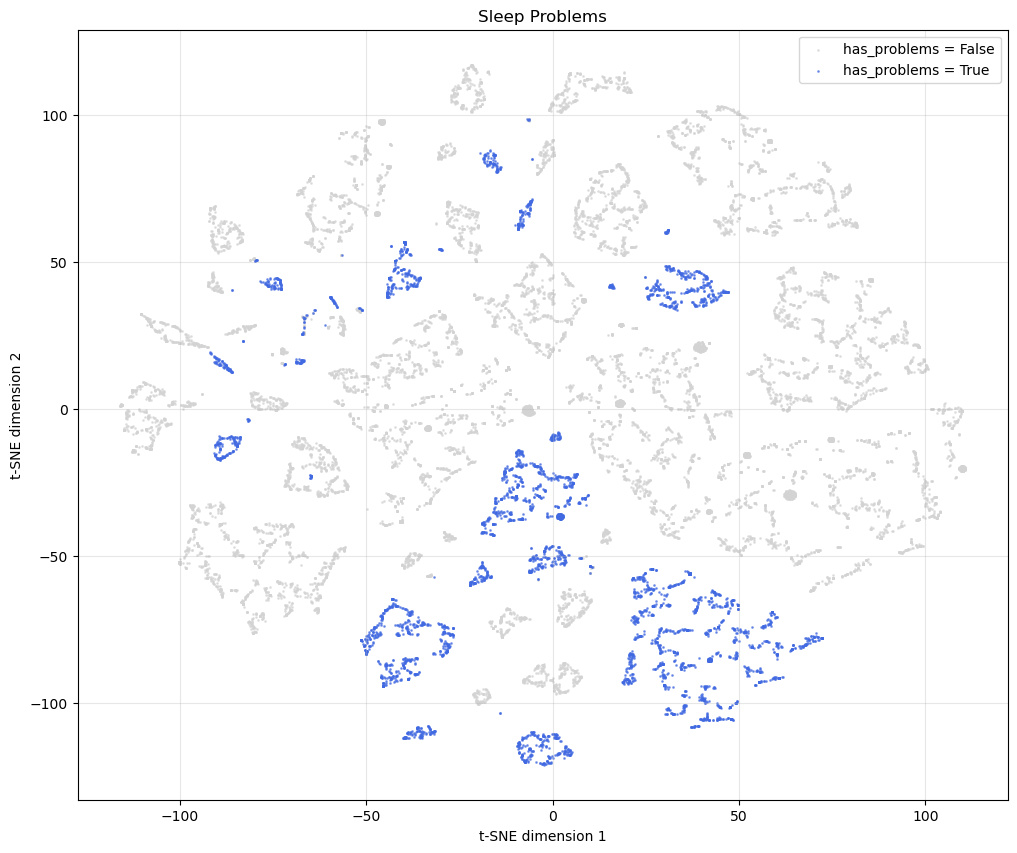

Statistics for has_problems:
True: 4755 (23.8%)
False: 15245 (76.2%)


In [56]:
visualize_tsne_by_boolean(sample_df, 'has_problems', title='Sleep Problems')


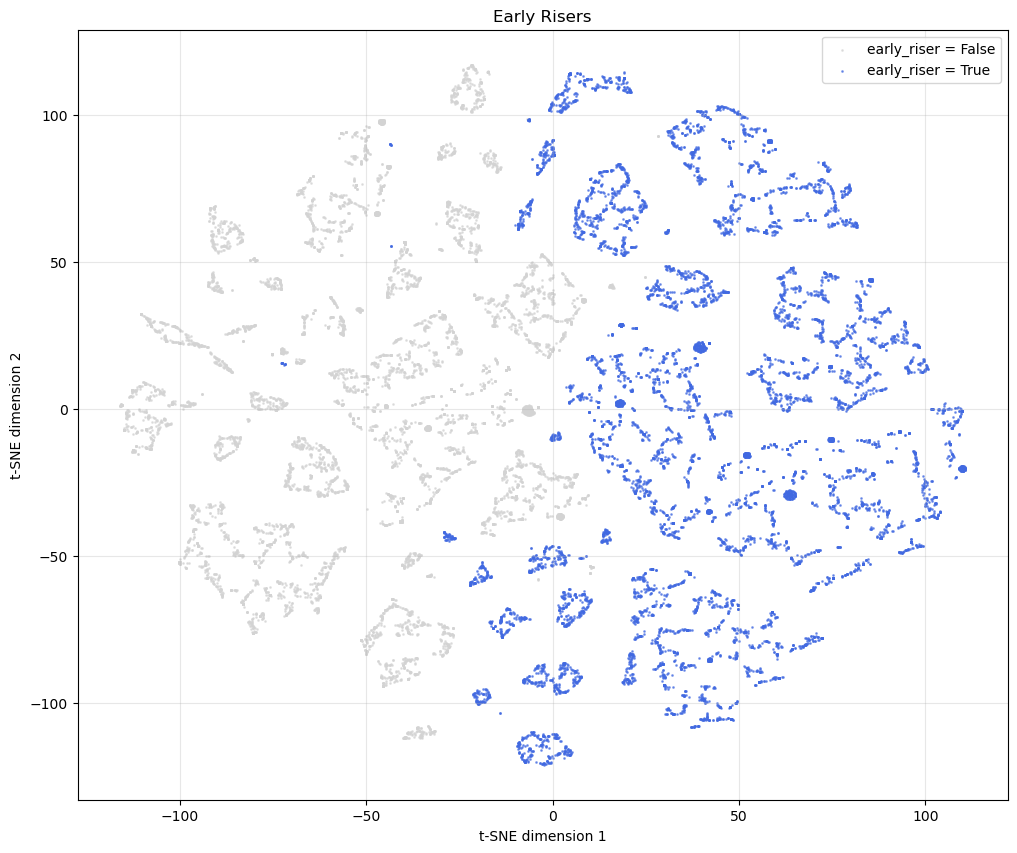

Statistics for early_riser:
True: 10793 (54.0%)
False: 9207 (46.0%)


In [57]:
visualize_tsne_by_boolean(sample_df, 'early_riser', title='Early Risers')

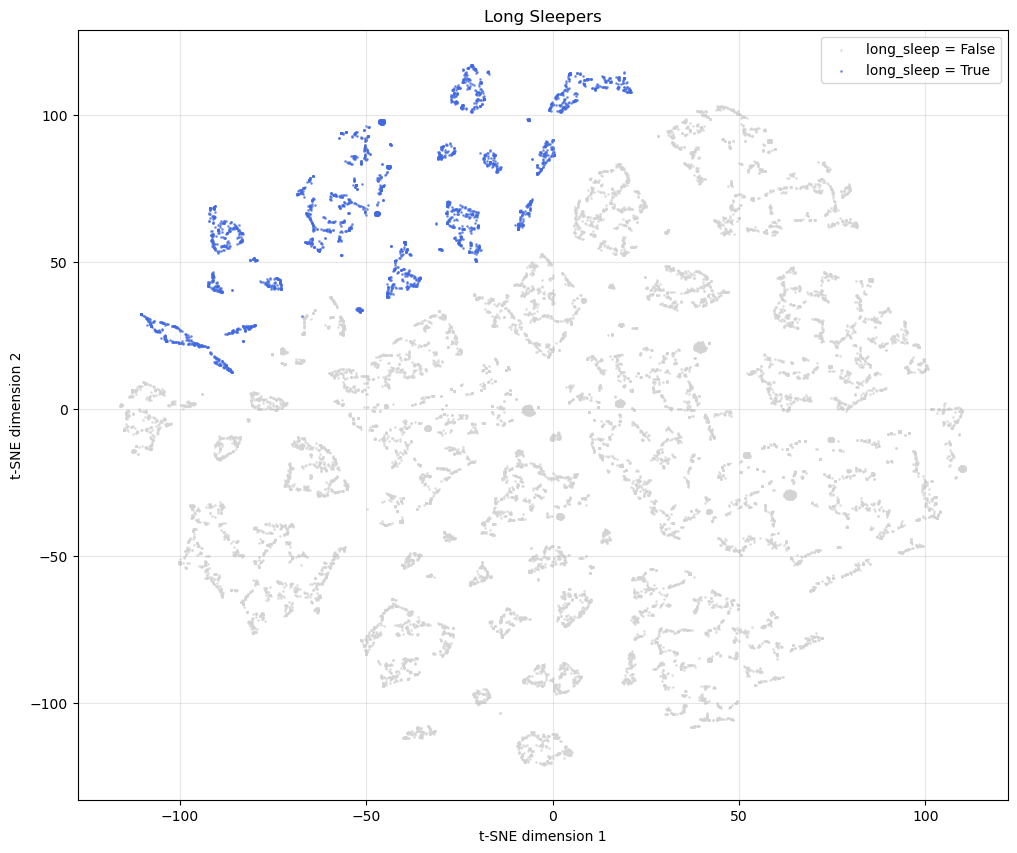

Statistics for long_sleep:
True: 3086 (15.4%)
False: 16914 (84.6%)


In [58]:
visualize_tsne_by_boolean(sample_df, 'long_sleep', title='Long Sleepers')

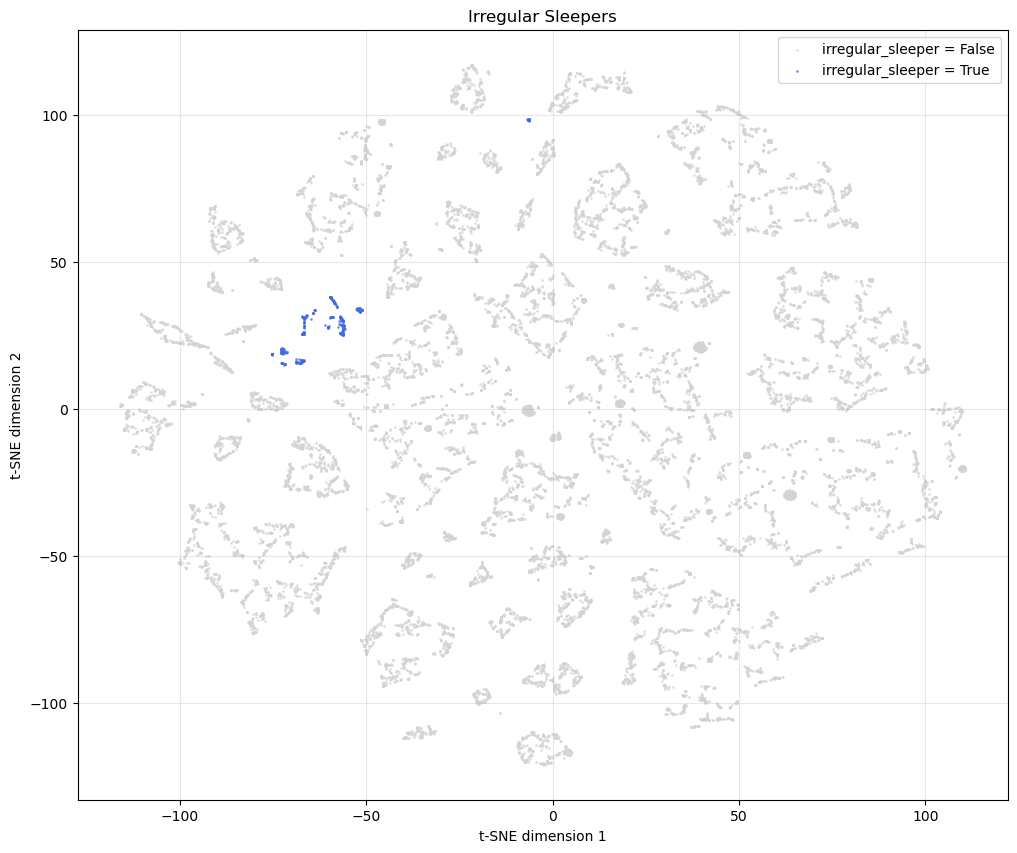

Statistics for irregular_sleeper:
True: 328 (1.6%)
False: 19672 (98.4%)


In [59]:
visualize_tsne_by_boolean(sample_df, 'irregular_sleeper', title='Irregular Sleepers')

In [60]:

# Step 7: Analyze the characteristics of each cluster
cluster_analysis = sample_df.groupby('cluster').agg({
    'early_sleeper': 'mean',
    'normal_sleeper': 'mean',
    'late_sleeper': 'mean',
    'irregular_sleeper': 'mean',
    'short_sleep': 'mean',
    'normal_sleep': 'mean',
    'long_sleep': 'mean',
    'early_riser': 'mean',
    'normal_riser': 'mean',
    'late_riser': 'mean',
    'sleep_duration_decimal': 'mean',
    'sleep_time_decimal': 'mean',
    'wakeup_time_decimal': 'mean',
    'satisfied': 'mean',
    'has_problems': 'mean'
}).round(2)

print("\nCluster Analysis:")
display(cluster_analysis)



Cluster Analysis:


,early_sleeper,normal_sleeper,late_sleeper,irregular_sleeper,short_sleep,normal_sleep,long_sleep,early_riser,normal_riser,late_riser,sleep_duration_decimal,sleep_time_decimal,wakeup_time_decimal,satisfied,has_problems
cluster,,,,,,,,,,,,,,,
0,0.01,0.66,0.33,0.00,0.25,0.75,0.00,0.62,0.38,0.00,6.74,15.66,6.48,0.06,0.67
1,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,7.07,22.84,5.99,0.37,0.00
2,0.00,0.31,0.62,0.07,0.03,0.87,0.09,0.00,0.69,0.30,7.77,8.15,8.50,0.17,0.08
3,0.99,0.00,0.00,0.01,0.00,0.67,0.33,0.84,0.16,0.00,8.47,21.28,5.82,0.31,0.04
4,0.07,0.93,0.00,0.00,0.00,0.00,1.00,0.06,0.71,0.23,9.54,22.56,8.22,0.21,0.25
5,0.18,0.82,0.00,0.00,0.00,1.00,0.00,0.57,0.42,0.00,8.00,22.50,6.57,0.36,0.19


In [61]:
food_users = set(user_items_enhanced['pid'].unique())
print(f"Food users: {len(food_users)}")
sleep_users = set(user_sleep_df['pid'].unique())
print(f"Sleep users: {len(sleep_users)}")

common_users = food_users & sleep_users

# Filter the DataFrame to only include common users
user_items_df = user_items_enhanced[user_items_enhanced['pid'].isin(common_users)]
user_sleep_df = user_sleep_df[user_sleep_df['pid'].isin(common_users)]

print(f"Common users: {len(common_users)}")

Food users: 20985
Sleep users: 20191
Common users: 20191


In [62]:
user_sleep_df = create_sleep_archetypes(user_sleep_df)

In [63]:
user_sleep_df

,pid,measured_date,enough_sleep,sleep_problems_bool,sleep_time_decimal,sleep_duration_decimal,wakeup_time_decimal,early_sleeper,normal_sleeper,late_sleeper,...,long_sleep,early_riser,normal_riser,late_riser,sleep_time_sin,sleep_time_cos,wakeup_time_sin,wakeup_time_cos,satisfied,has_problems
182239,alqt150211047,2021-10-02,False,True,22.583333,7.916667,6.500000,False,True,False,...,False,True,False,False,-0.362438,0.932008,0.991445,-0.130526,False,True
182240,alqt150211047,2021-10-28,False,True,23.166667,8.966667,8.133333,False,True,False,...,False,False,True,False,-0.216440,0.976296,0.848048,-0.529919,False,True
182241,alqt150211047,2021-10-29,True,False,23.500000,9.500000,9.000000,False,True,False,...,True,False,False,True,-0.130526,0.991445,0.707107,-0.707107,True,False
182242,alqt150211047,2021-10-30,False,True,22.333333,8.916667,7.250000,False,True,False,...,False,False,True,False,-0.422618,0.906308,0.946930,-0.321439,False,True
182243,alqt150211047,2021-10-31,True,False,22.500000,9.050000,7.550000,False,True,False,...,True,False,True,False,-0.382683,0.923880,0.918791,-0.394744,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743962,alqt230941256543,2023-09-26,False,True,22.500000,8.416667,6.916667,False,True,False,...,False,True,False,False,-0.382683,0.923880,0.971342,-0.237686,False,True
744053,alqt230941256543,2023-09-27,False,True,2.250000,5.250000,7.500000,False,False,True,...,False,False,True,False,0.555570,0.831470,0.923880,-0.382683,False,True
744130,alqt230941256543,2023-09-28,False,True,0.166667,8.333333,8.500000,False,False,True,...,False,False,True,False,0.043619,0.999048,0.793353,-0.608761,False,True
744162,alqt230941256543,2023-09-29,False,True,22.500000,6.566667,5.066667,False,True,False,...,False,True,False,False,-0.382683,0.923880,0.970296,0.241922,False,True


In [66]:
user_items_df

,pid,food_type,original_logtime,log_date,time_24h_decimal,food_item,food_cluster,cluster_representative,is_breakfast,is_lunch,is_dinner,is_late_night,time_period
0,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,nespresso,13,coffee,True,False,False,False,morning
1,alqt150211047,f,2021-10-28 09:45:59,2021-10-28,9.766389,oatmeal,70,oatmeal,True,False,False,False,morning
2,alqt150211047,f,2021-10-28 09:45:59,2021-10-28,9.766389,oatmeal,70,oatmeal,True,False,False,False,morning
3,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,milk,34,milk,True,False,False,False,morning
4,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,milk,34,milk,True,False,False,False,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240271,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,baked chicken,35,chicken,False,False,True,False,evening
4240272,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,mashed potato,67,potato,False,False,True,False,evening
4240273,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,salad,43,salad,False,False,True,False,evening
4240274,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,salad,43,salad,False,False,True,False,evening


### Demographics

In [139]:
demo_df = pd.read_csv('data/user_demographics.csv')
demo_df.head()

,gender,age,working_hours,age_group,pid
0,female,44.0,Flexible Schedule,Between 40 and 60,alqt150211047
1,female,29.0,Regular Work Hours Between 8AM-5PM,Under 40,alqt150211119
2,male,19.0,Regular Work Hours Between 8AM-5PM,Under 40,alqt150211143
3,male,21.0,Regular Work Hours Between 8AM-5PM,Under 40,alqt150211144
4,male,60.0,Regular Work Hours Between 8AM-5PM,Between 40 and 60,alqt150211157


In [145]:
demo_df['gender'].value_counts()

gender
female     13327
male        7636
unknown       20
other         12
Name: count, dtype: int64

# Graph Construction

In [130]:
import networkx as nx
from collections import defaultdict

# Create a heterogeneous graph
G = nx.Graph()

# 1. Add user nodes
unique_users = set(user_sleep_df['pid'].unique())
for user_id in unique_users:
    G.add_node(user_id, type='user')

# 2. Add food cluster nodes instead of individual food items
unique_clusters = user_items_df['cluster_representative'].dropna().unique()
for cluster in unique_clusters:
    G.add_node(f"food_{cluster}", type='food_cluster')

# 3. Add time-specific food cluster nodes
time_bin_labels = ['late_night', 'morning', 'midday', 'evening', 'late_night']
for cluster in unique_clusters:
    for time_label in time_bin_labels:
        G.add_node(f"food_{cluster}_{time_label}", type='food_cluster_time_specific')

# 4. Add sleep archetype nodes (unchanged)
sleep_archetypes = [
    'early_sleeper', 'normal_sleeper', 'late_sleeper', 'irregular_sleeper',
    'short_sleep', 'normal_sleep', 'long_sleep',
    'early_riser', 'normal_riser', 'late_riser',
    'satisfied', 'has_problems'
]
for archetype in sleep_archetypes:
    G.add_node(f"sleep_{archetype}", type='sleep_archetype')


In [131]:
# Display properties of the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 20703
Number of edges: 0


In [132]:

# 5. Count food entries per user for normalization
user_total_food_count = user_items_df.groupby('pid').size()

# 6. Get food cluster counts by user
user_cluster_counts = defaultdict(lambda: defaultdict(int))
for _, row in user_items_df.iterrows():
    if pd.notna(row['cluster_representative']):
        user_cluster_counts[row['pid']][row['cluster_representative']] += 1

# 7. Add normalized edges between users and food clusters
for user, clusters in user_cluster_counts.items():
    if user in user_total_food_count:
        total_entries = user_total_food_count[user]
        for cluster, count in clusters.items():
            # Normalize weight to [0-1] range
            normalized_weight = count / total_entries
            G.add_edge(user, f"food_{cluster}", 
                      weight=normalized_weight, 
                      raw_count=count,
                      type='consumes')


print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 20703
Number of edges: 739732


In [133]:

# 8. Add normalized edges for time-specific food clusters
user_cluster_time_counts = defaultdict(lambda: defaultdict(int))
for _, row in user_items_df.iterrows():
    if pd.notna(row['cluster_representative']) and pd.notna(row['time_period']):
        key = f"{row['cluster_representative']}_{row['time_period']}"
        user_cluster_time_counts[row['pid']][key] += 1

for user, cluster_times in user_cluster_time_counts.items():
    if user in user_total_food_count:
        total_entries = user_total_food_count[user]
        for cluster_time, count in cluster_times.items():
            normalized_weight = count / total_entries
            G.add_edge(user, f"food_{cluster_time}", 
                      weight=normalized_weight, 
                      raw_count=count,
                      type='consumes_at_time')
            
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 20903
Number of edges: 2104900


In [ ]:
sleep_augmented.columns

Index(['pid', 'measured_date', 'enough_sleep', 'sleep_problems_bool',
       'sleep_time_decimal', 'sleep_duration_decimal', 'wakeup_time_decimal',
       'early_sleeper', 'normal_sleeper', 'late_sleeper', 'irregular_sleeper',
       'short_sleep', 'normal_sleep', 'long_sleep', 'early_riser',
       'normal_riser', 'late_riser', 'sleep_time_sin', 'sleep_time_cos',
       'wakeup_time_sin', 'wakeup_time_cos', 'satisfied', 'has_problems'],
      dtype='object')

In [136]:
# 9. Add sleep archetype nodes
sleep_archetypes = [
    'early_sleeper', 'normal_sleeper', 'late_sleeper', 'irregular_sleeper',
    'short_sleep', 'normal_sleep', 'long_sleep',
    'early_riser', 'normal_riser', 'late_riser',
    'satisfied', 'has_problems'
]
for archetype in sleep_archetypes:
    G.add_node(f"sleep_{archetype}", type='sleep_archetype')

# 10. Add edges between users and sleep archetypes using pre-calculated values
sleep_records_per_user = sleep_augmented.groupby('pid').size()

# Process each user's sleep data
for pid, user_sleep in sleep_augmented.groupby('pid'):
    total_records = len(user_sleep)
    
    # Process each sleep archetype
    for archetype in sleep_archetypes:
        if archetype in user_sleep.columns:
            # Get the average value for this archetype across all records
            archetype_value = user_sleep[archetype].mean()
            
            # Only add edges for non-zero values
            if archetype_value > 0:
                G.add_edge(pid, f"sleep_{archetype}", 
                          weight=archetype_value,  # Already normalized between 0-1
                          raw_count=int(archetype_value * total_records),
                          type='has_sleep_pattern')

# Print graph statistics
print(f"Graph created with {len(G.nodes())} nodes and {len(G.edges())} edges")
print(f"Number of users: {len([n for n, attrs in G.nodes(data=True) if attrs.get('type') == 'user'])}")
print(f"Number of food clusters: {len([n for n, attrs in G.nodes(data=True) if attrs.get('type') == 'food_cluster'])}")
print(f"Number of time-specific food clusters: {len([n for n, attrs in G.nodes(data=True) if attrs.get('type') == 'food_cluster_time_specific'])}")
print(f"Number of sleep archetype connections: {len([(u,v) for u,v,d in G.edges(data=True) if d.get('type')=='has_sleep_pattern'])}")

Graph created with 20903 nodes and 2269360 edges
Number of users: 20191
Number of food clusters: 100
Number of time-specific food clusters: 400
Number of sleep archetype connections: 164460


In [147]:
# Save G using pickle 
with open('graph.pkl', 'wb') as f:
    pickle.dump(G, f)

In [148]:
# 11. Add demographic nodes and edges

# Age cohorts - create more granular age brackets
age_brackets = [
    (18, 30, 'young_adult'),
    (30, 40, 'thirties'),
    (40, 50, 'forties'),
    (50, 60, 'fifties'),
    (60, 100, 'senior')
]

# Add demographic category nodes
for start, end, label in age_brackets:
    G.add_node(f"age_{label}", type='demographic')

# Add working hours nodes
working_hours_categories = [
    'regular_work_hours', 
    'flexible_schedule',
    'long_work_hours',
    'rotating_shift',
    'morning_shift',
    'evening_shift',
    'night_shift'
]
for category in working_hours_categories:
    G.add_node(f"work_{category}", type='demographic')

# Add gender nodes
gender_categories = ['female', 'male', 'other']
for category in gender_categories:
    G.add_node(f"gender_{category}", type='demographic')

# Connect users to their demographic nodes
for _, row in demo_df.iterrows():
    user = row['pid']
    
    # Skip if user not in graph
    if user not in G:
        continue
    
    # Add age edge
    if pd.notna(row['age']):
        age = row['age']
        for start, end, label in age_brackets:
            if start <= age < end:
                G.add_edge(user, f"age_{label}", weight=1.0, type='has_demographic')
                break
    
    # Add working hours edge
    if pd.notna(row['working_hours']) and row['working_hours'] != 'Unknown':
        # Clean the working hours string to match node names
        work_category = row['working_hours'].lower().replace(' ', '_').replace('-', '_')
        if 'between_8am_5pm' in work_category:
            work_category = 'regular_work_hours'
        
        G.add_edge(user, f"work_{work_category}", weight=1.0, type='has_demographic')
    
    # Add gender edge
    if pd.notna(row['gender']) and row['gender'] != 'unknown':
        gender = row['gender'].lower()
        G.add_edge(user, f"gender_{gender}", weight=1.0, type='has_demographic')

# Print updated graph statistics
print(f"Updated graph: {len(G.nodes())} nodes and {len(G.edges())} edges")
print(f"Number of demographic connections: {len([(u,v) for u,v,d in G.edges(data=True) if d.get('type')=='has_demographic'])}")

# Print demographic coverage
demo_users = set([u for u,v,d in G.edges(data=True) if d.get('type')=='has_demographic'])
total_users = len([n for n,attrs in G.nodes(data=True) if attrs.get('type')=='user'])
print(f"Demographic data coverage: {len(demo_users)}/{total_users} users ({len(demo_users)/total_users*100:.1f}%)")

Updated graph: 20918 nodes and 2327885 edges
Number of demographic connections: 58525
Demographic data coverage: 20181/20191 users (100.0%)


In [149]:
# Summarize edge types and their distributions
edge_type_summary = defaultdict(list)

# Loop through all edges
for u, v, data in G.edges(data=True):
    edge_type = data.get('type', 'unknown')
    weight = data.get('weight', 0)
    raw_count = data.get('raw_count', 0)
    
    # Store the data
    edge_type_summary[edge_type].append({
        'weight': weight,
        'raw_count': raw_count
    })

# Print summary statistics for each edge type
print("\nEDGE TYPE SUMMARY:")
print("=" * 60)
for edge_type, values in edge_type_summary.items():
    weights = [item['weight'] for item in values]
    counts = [item['raw_count'] for item in values]
    
    print(f"\nEdge Type: {edge_type}")
    print(f"  Number of edges: {len(values)}")
    print(f"  Weight statistics: min={min(weights):.4f}, max={max(weights):.4f}, mean={np.mean(weights):.4f}, median={np.median(weights):.4f}")
    if counts[0] > 0:  # Only print raw count stats if they exist
        print(f"  Count statistics: min={min(counts)}, max={max(counts)}, mean={np.mean(counts):.1f}, median={np.median(counts)}")
    
    # Show distribution of top destination nodes
    if edge_type.startswith('consumes'):
        node_counts = defaultdict(int)
        for u, v, data in G.edges(data=True):
            if data.get('type') == edge_type:
                node_counts[v] += 1
        
        print("  Top destination nodes:")
        for node, count in sorted(node_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"    {node}: {count} connections")
            
print("=" * 60)


EDGE TYPE SUMMARY:

Edge Type: consumes
  Number of edges: 739732
  Weight statistics: min=0.0010, max=1.0000, mean=0.0273, median=0.0140
  Count statistics: min=1, max=391, mean=5.5, median=3.0
  Top destination nodes:
    food_salad: 17483 connections
    food_coffee: 16969 connections
    food_egg: 15838 connections
    food_chicken: 14676 connections
    food_cheese: 14471 connections

Edge Type: consumes_at_time
  Number of edges: 1365168
  Weight statistics: min=0.0010, max=1.0000, mean=0.0148, median=0.0083
  Count statistics: min=1, max=276, mean=3.0, median=2.0
  Top destination nodes:
    food_coffee_morning: 14722 connections
    food_coffee_midday: 14330 connections
    food_salad_midday: 12827 connections
    food_salad_evening: 12514 connections
    food_egg_midday: 11443 connections

Edge Type: has_sleep_pattern
  Number of edges: 164460
  Weight statistics: min=0.0008, max=1.0000, mean=0.4248, median=0.3571
  Count statistics: min=0, max=1622, mean=14.5, median=7.0

Ed

In [77]:
# Find users who only logged one type of food cluster
user_cluster_diversity = user_items_df.groupby('pid')['cluster_representative'].nunique()
single_cluster_users = user_cluster_diversity[user_cluster_diversity == 1].index.tolist()

# Get details about these users
single_cluster_user_details = []
for user in single_cluster_users:
    user_data = user_items_df[user_items_df['pid'] == user]
    single_cluster_user_details.append({
        'user_id': user,
        'food_cluster': user_data['cluster_representative'].iloc[0],
        'num_entries': len(user_data),
        'time_periods': user_data['time_period'].unique().tolist(),
        'date_range': [user_data['log_date'].min(), user_data['log_date'].max()]
    })

# Create a DataFrame for easy viewing
single_cluster_df = pd.DataFrame(single_cluster_user_details)

# Sort by number of entries to find interesting cases
single_cluster_df = single_cluster_df.sort_values('num_entries', ascending=False)

# Display the top users with only one food cluster
print(f"Found {len(single_cluster_users)} users who only logged one type of food cluster")
print("\nTop users with highest number of entries:")
display(single_cluster_df.head(10))

Found 27 users who only logged one type of food cluster

Top users with highest number of entries:


,user_id,food_cluster,num_entries,time_periods,date_range
11,alqt150230524245754,oatmeal,55,"[midday, morning, afternoon, night]","[2023-05-14, 2023-05-27]"
18,alqt181067507,coffee,26,"[night, morning, midday]","[2018-10-18, 2018-10-31]"
1,alqt150220126197891,coffee,26,"[midday, morning]","[2022-01-10, 2022-01-23]"
4,alqt150221003220766,banana,25,"[morning, evening, midday, afternoon]","[2022-10-05, 2022-10-18]"
25,alqt210435178131,coffee,24,"[morning, afternoon, midday]","[2021-04-24, 2021-05-06]"
16,alqt180849620,coffee,20,"[morning, afternoon, night]","[2018-08-08, 2018-08-20]"
9,alqt150230341239969,tea,19,"[afternoon, midday, evening, morning]","[2023-03-26, 2023-04-06]"
3,alqt150220948218528,coffee,18,"[morning, midday]","[2022-09-05, 2022-09-14]"
21,alqt190691052,coffee,18,"[morning, midday]","[2019-06-11, 2019-06-23]"
14,alqt180636837,coffee,18,"[morning, midday]","[2018-06-16, 2018-06-27]"


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Extract unique food items and their embeddings
unique_foods = {}
for _, row in user_items_df.iterrows():
    if row['food_item'] not in unique_foods:
        unique_foods[row['food_item']] = row['embedding']

# Convert to lists for easier processing
food_names = list(unique_foods.keys())
food_embeddings = np.array(list(unique_foods.values()))

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(food_embeddings)

In [ ]:
2661**2

In [ ]:
import pickle 

with open('food_similarity_matrix.pkl', 'wb') as f:
    pickle.dump(similarity_matrix, f)

In [ ]:
with open("graph.pkl", 'wb') as f:
    pickle.dump(G, f)

In [ ]:
user_sleep_df

In [ ]:
similarity_matrix

In [ ]:
food_similarity_edges = []

threshold = 0.65

s = 0
for i in range(len(food_names)):
    for j in range(i+1, len(food_names)):  # Start from i+1 to avoid duplicate edges
        similarity = similarity_matrix[i, j]
        if similarity > threshold:
            s += 1
            # food_similarity_edges.append((
            #     f"food_{food_names[i]}",
            #     f"food_{food_names[j]}",
            #     {'weight': similarity, 'type': 'similar_to'}
            # ))

# Add edges to graph
# G.add_edges_from(food_similarity_edges)

print(f"Added {s} food similarity edges")

In [ ]:
# Display properties of the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

### Graph Exploration

In [138]:
# Count nodes by type
node_types = {}
for node, data in G.nodes(data=True):
    node_type = data.get('type', 'unknown')
    node_types[node_type] = node_types.get(node_type, 0) + 1

print("Node types:")
for node_type, count in node_types.items():
    print(f"  {node_type}: {count}")

# Count edges by type
edge_types = {}
for u, v, data in G.edges(data=True):
    edge_type = data.get('type', 'unknown')
    edge_types[edge_type] = edge_types.get(edge_type, 0) + 1

print("\nEdge types:")
for edge_type, count in edge_types.items():
    print(f"  {edge_type}: {count}")

# Get degree distribution for user nodes
user_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'user']
user_degrees = [G.degree(node) for node in user_nodes]

import numpy as np
print(f"\nUser node degree stats:")
print(f"  Min: {np.min(user_degrees)}")
print(f"  Max: {np.max(user_degrees)}")
print(f"  Mean: {np.mean(user_degrees):.2f}")
print(f"  Median: {np.median(user_degrees):.2f}")

Node types:
  user: 20191
  food_cluster: 100
  food_cluster_time_specific: 400
  sleep_archetype: 12
  unknown: 200

Edge types:
  consumes: 739732
  consumes_at_time: 1365168
  has_sleep_pattern: 164460

User node degree stats:
  Min: 7
  Max: 261
  Mean: 112.39
  Median: 111.00


# Clustering

## K-Means

In [150]:
import numpy as np
import scipy.sparse as sp
from sklearn.cluster import KMeans
import tqdm
import pickle

# Step 1: Create a bipartite adjacency matrix
# This represents connections between users and features (food, sleep, etc.)
print("Building adjacency matrix...")

# Get user nodes
user_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'user']
print(f"Found {len(user_nodes)} user nodes")

# Get feature nodes (non-user nodes)
feature_nodes = [node for node, data in G.nodes(data=True) if data.get('type') != 'user']
print(f"Found {len(feature_nodes)} feature nodes")

# Create mappings for row and column indices
user_to_idx = {user: i for i, user in enumerate(user_nodes)}
feature_to_idx = {feature: i for i, feature in enumerate(feature_nodes)}

# Initialize sparse matrix data
row_indices = []
col_indices = []
values = []

# Fill matrix with edge data
for user in tqdm.tqdm(user_nodes, desc="Building adjacency matrix"):
    for neighbor in G.neighbors(user):
        # Skip edges between users
        if G.nodes[neighbor].get('type') == 'user':
            continue
            
        # Get indices
        user_idx = user_to_idx[user]
        feature_idx = feature_to_idx[neighbor]
        
        # Get edge weight
        weight = G[user][neighbor].get('weight', 1.0)
        
        # Add to sparse matrix data
        row_indices.append(user_idx)
        col_indices.append(feature_idx)
        values.append(weight)

# Create sparse matrix
adjacency = sp.csr_matrix((values, (row_indices, col_indices)), 
                          shape=(len(user_nodes), len(feature_nodes)))

print(f"Created adjacency matrix with shape {adjacency.shape}")

# Step 2: Normalize rows to account for different activity levels
print("Normalizing adjacency matrix...")
row_sums = adjacency.sum(axis=1).A.flatten()
# Avoid division by zero
row_sums[row_sums == 0] = 1
normalized_adjacency = adjacency.multiply(1 / row_sums[:, np.newaxis])

# Step 3: Calculate user similarity matrix
# For large matrices, we can project to lower dimension first
from sklearn.decomposition import TruncatedSVD

print("Performing dimensionality reduction...")
n_components = min(100, min(normalized_adjacency.shape) - 1)
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_features = svd.fit_transform(normalized_adjacency)
print(f"Reduced to {n_components} dimensions, explained variance: {svd.explained_variance_ratio_.sum():.2%}")


Building adjacency matrix...
Found 20191 user nodes
Found 727 feature nodes


Building adjacency matrix: 100%|██████████| 20191/20191 [00:01<00:00, 13599.36it/s]


Created adjacency matrix with shape (20191, 727)
Normalizing adjacency matrix...
Performing dimensionality reduction...
Reduced to 100 dimensions, explained variance: 99.60%


In [151]:

# Step 4: Cluster the reduced features
print("Clustering users...")
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
clusters = kmeans.fit_predict(reduced_features)

# Step 5: Map back to user IDs
user_clusters = {user: cluster for user, cluster in zip(user_nodes, clusters)}

# Show cluster distribution
from collections import Counter
cluster_counts = Counter(user_clusters.values())
print("\nCluster distribution:")
for cluster_id, count in sorted(cluster_counts.items()):
    print(f"Cluster {cluster_id}: {count} users ({count/len(user_clusters)*100:.1f}%)")

# Save results
print("Saving clustering results...")
with open('user_clusters.pkl', 'wb') as f:
    pickle.dump(user_clusters, f)

# Step 6: Analyze what makes each cluster unique
print("\nAnalyzing cluster characteristics...")

# Get top features for each cluster
def get_top_features_per_cluster(cluster_id, top_n=20):
    # Get user indices for this cluster
    user_indices = [user_to_idx[user] for user, cluster in user_clusters.items() if cluster == cluster_id]
    
    # Get average feature values for this cluster
    cluster_features = adjacency[user_indices].mean(axis=0).A.flatten()
    
    # Get average feature values across all users
    all_features = adjacency.mean(axis=0).A.flatten()
    
    # Calculate the ratio of cluster average to global average
    # Add small epsilon to avoid division by zero
    feature_ratios = cluster_features / (all_features + 1e-10)
    
    # Get indices of top features
    top_indices = np.argsort(-feature_ratios)[:top_n]
    
    # Map back to feature names
    idx_to_feature = {i: feature for feature, i in feature_to_idx.items()}
    
    return [(idx_to_feature[i], feature_ratios[i]) for i in top_indices if feature_ratios[i] > 1.0]

# Show top distinctive features for each cluster
for cluster_id in sorted(cluster_counts.keys()):
    top_features = get_top_features_per_cluster(cluster_id)
    
    print(f"\nCluster {cluster_id} ({cluster_counts[cluster_id]} users) - Distinctive features:")
    for feature, ratio in top_features:
        print(f"  {feature}: {ratio:.2f}x average")

Clustering users...

Cluster distribution:
Cluster 0: 3431 users (17.0%)
Cluster 1: 2862 users (14.2%)
Cluster 2: 3203 users (15.9%)
Cluster 3: 2708 users (13.4%)
Cluster 4: 4378 users (21.7%)
Cluster 5: 3609 users (17.9%)
Saving clustering results...

Analyzing cluster characteristics...

Cluster 0 (3431 users) - Distinctive features:
  work_regular_work_hours: 2.59x average
  age_fifties: 1.62x average
  food_pudding_morning: 1.59x average
  gender_female: 1.56x average
  food_candy_morning: 1.49x average
  food_pasty_morning: 1.49x average
  food_caramel_morning: 1.37x average
  age_thirties: 1.36x average
  food_cinnamon_morning: 1.35x average
  food_matcha_evening: 1.30x average
  food_pudding_afternoon: 1.29x average
  food_soup_morning: 1.29x average
  food_dressing_midday: 1.28x average
  age_young_adult: 1.27x average
  food_caramel_midday: 1.26x average
  food_dressing_morning: 1.25x average
  food_cracker_midday: 1.25x average
  food_coconut_morning: 1.24x average
  food_pas

In [152]:
user_items_df['kmeans_cluster_6'] = user_items_df['pid'].map(user_clusters)

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_43703/4103126970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_items_df['kmeans_cluster_6'] = user_items_df['pid'].map(user_clusters)


In [153]:
# Analyze sleep patterns specifically
print("\nAnalyzing sleep patterns by cluster...")

# Get sleep feature nodes
sleep_features = [node for node, data in G.nodes(data=True) 
                 if data.get('type') == 'sleep_archetype']
sleep_indices = [feature_to_idx[feature] for feature in sleep_features 
                if feature in feature_to_idx]

# For each cluster, calculate average sleep feature values
for cluster_id in sorted(cluster_counts.keys()):
    # Get user indices for this cluster
    user_indices = [user_to_idx[user] for user, cluster in user_clusters.items() 
                   if cluster == cluster_id]
    
    # Get average sleep feature values for this cluster
    cluster_sleep_features = adjacency[user_indices][:, sleep_indices].mean(axis=0).A.flatten()
    
    # Get average sleep feature values across all users
    all_sleep_features = adjacency[:, sleep_indices].mean(axis=0).A.flatten()
    
    # Calculate the ratio of cluster average to global average
    sleep_feature_ratios = cluster_sleep_features / (all_sleep_features + 1e-10)
    
    # Map indices back to feature names
    idx_to_feature = {feature_to_idx[feature]: feature for feature in sleep_features 
                      if feature in feature_to_idx}
    
    print(f"\nCluster {cluster_id} ({cluster_counts[cluster_id]} users) - Sleep patterns:")
    for i, ratio in sorted(enumerate(sleep_feature_ratios), key=lambda x: -x[1]):
        feature = idx_to_feature[sleep_indices[i]]
        print(f"  {feature}: {ratio:.2f}x average")


Analyzing sleep patterns by cluster...

Cluster 0 (3431 users) - Sleep patterns:
  sleep_early_sleeper: 1.19x average
  sleep_early_riser: 1.07x average
  sleep_long_sleep: 1.05x average
  sleep_normal_sleeper: 1.05x average
  sleep_has_problems: 1.05x average
  sleep_normal_sleep: 1.02x average
  sleep_normal_riser: 0.97x average
  sleep_satisfied: 0.89x average
  sleep_late_sleeper: 0.77x average
  sleep_short_sleep: 0.73x average
  sleep_late_riser: 0.69x average
  sleep_irregular_sleeper: 0.51x average

Cluster 1 (2862 users) - Sleep patterns:
  sleep_early_riser: 1.12x average
  sleep_normal_sleep: 1.05x average
  sleep_normal_sleeper: 1.05x average
  sleep_satisfied: 1.02x average
  sleep_early_sleeper: 0.99x average
  sleep_short_sleep: 0.96x average
  sleep_normal_riser: 0.92x average
  sleep_has_problems: 0.91x average
  sleep_late_sleeper: 0.90x average
  sleep_long_sleep: 0.76x average
  sleep_late_riser: 0.65x average
  sleep_irregular_sleeper: 0.59x average

Cluster 2 (32

In [154]:
def analyze_clusters(user_items_df, cluster_column, G, user_to_idx, feature_to_idx, adjacency, top_n=20):
    """
    Analyze clusters based on their distinctive features and sleep patterns.
    
    Parameters:
    -----------
    user_items_df : pandas DataFrame
        DataFrame containing user data with cluster assignments
    cluster_column : str
        Name of the column containing cluster assignments
    G : networkx Graph
        The graph containing nodes and edges
    user_to_idx : dict
        Mapping from user IDs to row indices in adjacency matrix
    feature_to_idx : dict
        Mapping from feature names to column indices in adjacency matrix
    adjacency : scipy sparse matrix
        Adjacency matrix representing user-feature connections
    top_n : int, optional
        Number of top features to display for each cluster
        
    Returns:
    --------
    dict
        Dictionary containing analysis results for each cluster
    """
    # Get unique users and their cluster assignments
    user_clusters = {}
    for pid, cluster in user_items_df[['pid', cluster_column]].drop_duplicates().values:
        if not pd.isna(cluster):  # Skip null values
            user_clusters[pid] = int(cluster)  # Ensure cluster ID is an integer
    
    # Count users in each cluster
    from collections import Counter
    cluster_counts = Counter(user_clusters.values())
    print(f"\nCluster distribution for {cluster_column}:")
    for cluster_id, count in sorted(cluster_counts.items()):
        print(f"Cluster {cluster_id}: {count} users ({count/len(user_clusters)*100:.1f}%)")
    
    # Store analysis results
    results = {'cluster_counts': cluster_counts, 'features': {}, 'sleep': {}}
    
    # Analyze distinctive features for each cluster
    print("\nAnalyzing distinctive features by cluster...")
    
    for cluster_id in sorted(cluster_counts.keys()):
        # Get user indices for this cluster
        user_indices = [user_to_idx[user] for user, cluster in user_clusters.items() 
                      if cluster == cluster_id and user in user_to_idx]
        
        if not user_indices:
            print(f"Warning: No users found in adjacency matrix for cluster {cluster_id}")
            continue
            
        # Get average feature values for this cluster
        cluster_features = adjacency[user_indices].mean(axis=0).A.flatten()
        
        # Get average feature values across all users
        all_features = adjacency.mean(axis=0).A.flatten()
        
        # Calculate the ratio of cluster average to global average
        feature_ratios = cluster_features / (all_features + 1e-10)
        
        # Get indices of top features
        top_indices = np.argsort(-feature_ratios)[:top_n]
        
        # Map back to feature names
        idx_to_feature = {i: feature for feature, i in feature_to_idx.items()}
        
        top_features = [(idx_to_feature[i], feature_ratios[i]) for i in top_indices if feature_ratios[i] > 1.0]
        results['features'][cluster_id] = top_features
        
        print(f"\nCluster {cluster_id} ({cluster_counts[cluster_id]} users) - Distinctive features:")
        for feature, ratio in top_features:
            print(f"  {feature}: {ratio:.2f}x average")
    
    # Analyze sleep patterns specifically
    print("\nAnalyzing sleep patterns by cluster...")
    
    # Get sleep feature nodes
    sleep_features = [node for node, data in G.nodes(data=True) 
                     if data.get('type') == 'sleep_archetype']
    sleep_indices = [feature_to_idx[feature] for feature in sleep_features 
                    if feature in feature_to_idx]
    
    for cluster_id in sorted(cluster_counts.keys()):
        # Get user indices for this cluster
        user_indices = [user_to_idx[user] for user, cluster in user_clusters.items() 
                       if cluster == cluster_id and user in user_to_idx]
        
        if not user_indices:
            continue
            
        # Get average sleep feature values for this cluster
        cluster_sleep_features = adjacency[user_indices][:, sleep_indices].mean(axis=0).A.flatten()
        
        # Get average sleep feature values across all users
        all_sleep_features = adjacency[:, sleep_indices].mean(axis=0).A.flatten()
        
        # Calculate the ratio of cluster average to global average
        sleep_feature_ratios = cluster_sleep_features / (all_sleep_features + 1e-10)
        
        # Map indices back to feature names
        idx_to_feature = {feature_to_idx[feature]: feature for feature in sleep_features 
                          if feature in feature_to_idx}
        
        sleep_patterns = [(idx_to_feature[sleep_indices[i]], ratio) 
                          for i, ratio in enumerate(sleep_feature_ratios)]
        sleep_patterns.sort(key=lambda x: x[1], reverse=True)
        results['sleep'][cluster_id] = sleep_patterns
        
        print(f"\nCluster {cluster_id} ({cluster_counts[cluster_id]} users) - Sleep patterns:")
        for feature, ratio in sleep_patterns:
            print(f"  {feature}: {ratio:.2f}x average")
    
    return results

# Example usage:
results = analyze_clusters(user_items_df, 'kmeans_cluster_6', G, user_to_idx, feature_to_idx, adjacency)


Cluster distribution for kmeans_cluster_6:
Cluster 0: 3431 users (17.0%)
Cluster 1: 2862 users (14.2%)
Cluster 2: 3203 users (15.9%)
Cluster 3: 2708 users (13.4%)
Cluster 4: 4378 users (21.7%)
Cluster 5: 3609 users (17.9%)

Analyzing distinctive features by cluster...

Cluster 0 (3431 users) - Distinctive features:
  work_regular_work_hours: 2.59x average
  age_fifties: 1.62x average
  food_pudding_morning: 1.59x average
  gender_female: 1.56x average
  food_candy_morning: 1.49x average
  food_pasty_morning: 1.49x average
  food_caramel_morning: 1.37x average
  age_thirties: 1.36x average
  food_cinnamon_morning: 1.35x average
  food_matcha_evening: 1.30x average
  food_pudding_afternoon: 1.29x average
  food_soup_morning: 1.29x average
  food_dressing_midday: 1.28x average
  age_young_adult: 1.27x average
  food_caramel_midday: 1.26x average
  food_dressing_morning: 1.25x average
  food_cracker_midday: 1.25x average
  food_coconut_morning: 1.24x average
  food_pasty_night: 1.24x aver

### Elbow

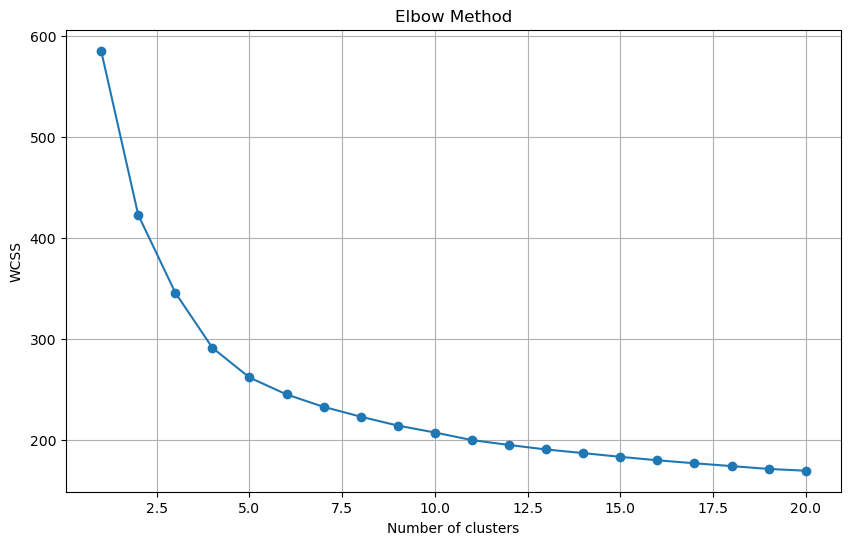

In [89]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
max_clusters = 20

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(reduced_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

### Silhouette

For n_clusters = 2, the silhouette score is 0.254
For n_clusters = 3, the silhouette score is 0.239
For n_clusters = 4, the silhouette score is 0.228
For n_clusters = 5, the silhouette score is 0.216
For n_clusters = 6, the silhouette score is 0.205
For n_clusters = 7, the silhouette score is 0.184
For n_clusters = 8, the silhouette score is 0.168
For n_clusters = 9, the silhouette score is 0.157
For n_clusters = 10, the silhouette score is 0.150
For n_clusters = 11, the silhouette score is 0.153
For n_clusters = 12, the silhouette score is 0.145
For n_clusters = 13, the silhouette score is 0.144
For n_clusters = 14, the silhouette score is 0.135


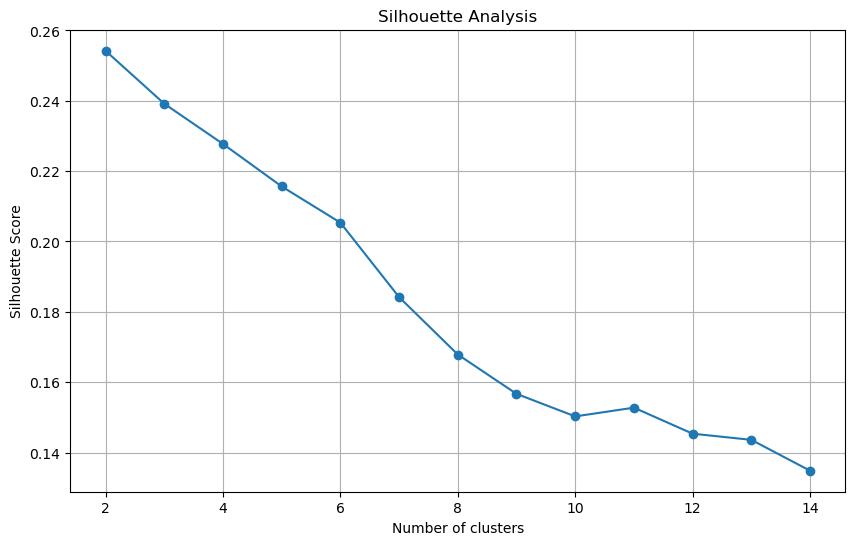

In [90]:
from sklearn.metrics import silhouette_score
import numpy as np

silhouette_scores = []
range_n_clusters = range(2, 15)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(reduced_features)
    silhouette_avg = silhouette_score(reduced_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Estimate a good epsilon value (neighborhood radius)
nn = NearestNeighbors(n_neighbors=10)
nn.fit(reduced_features)
distances, indices = nn.kneighbors(reduced_features)

# Sort distances to the 10th nearest neighbor
distances = np.sort(distances[:, -1])

# Plot to find the "elbow"
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel('Distance to 10th Nearest Neighbor')
plt.grid(True)
plt.show()

# Choose epsilon based on the elbow in the plot
epsilon = float(input("Enter the epsilon value based on the elbow in the plot: "))

# Apply DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=10)
dbscan_labels = dbscan.fit_predict(reduced_features)

# Count the number of clusters (excluding noise points labeled as -1)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN found {n_clusters} clusters and {(dbscan_labels == -1).sum()} noise points")
print(f"Epsilon: {epsilon}")

# Map back to user IDs
dbscan_clusters = {user: label for user, label in zip(user_nodes, dbscan_labels)}

# Show cluster distribution
from collections import Counter
cluster_counts = Counter(dbscan_clusters.values())
print("\nCluster distribution:")
for cluster_id, count in sorted(cluster_counts.items()):
    print(f"Cluster {cluster_id}: {count} users ({count/len(dbscan_clusters)*100:.1f}%)")

## Agglomerative Clustering with Dynamic Tree Cut

Computing linkage for hierarchical clustering...


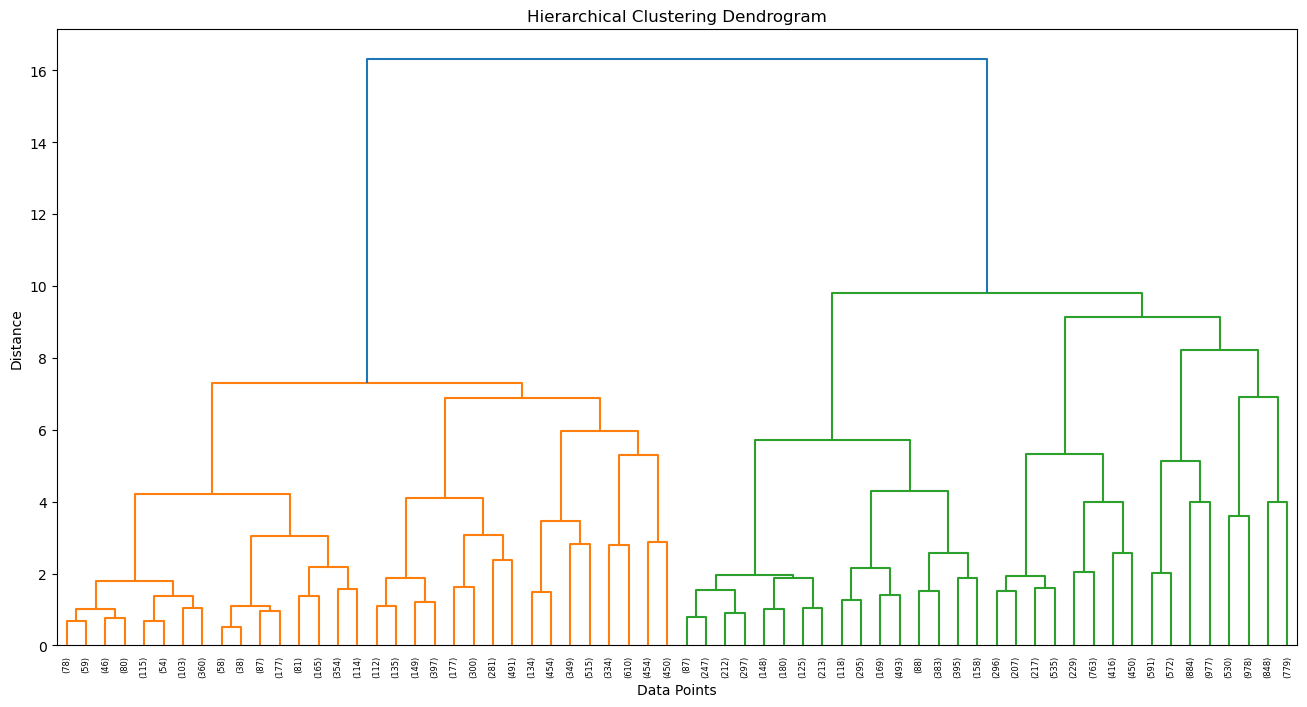

Distance threshold: 4.5
Hierarchical clustering found 13 clusters


In [159]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Fix seed for reproducibility
np.random.seed(42)

# Compute linkage matrix
print("Computing linkage for hierarchical clustering...")
# For large datasets, sample to make computation feasible
sample_size = min(30000, reduced_features.shape[0])
if reduced_features.shape[0] > sample_size:
    indices = np.random.choice(reduced_features.shape[0], sample_size, replace=False)
    sample_features = reduced_features[indices]
else:
    sample_features = reduced_features
    indices = np.arange(reduced_features.shape[0])

Z = linkage(sample_features, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.axhline(y=200, color='r', linestyle='--')  # Adjust this threshold based on the dendrogram
plt.show()

# Choose a distance threshold based on the dendrogram
threshold = float(input("Enter the distance threshold from the dendrogram: "))
print(f"Distance threshold: {threshold}")

# Apply hierarchical clustering with the chosen threshold
hc = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=threshold,
    linkage='ward'
)
hc_labels = hc.fit_predict(reduced_features)

# Count the number of clusters
n_clusters = len(set(hc_labels))
print(f"Hierarchical clustering found {n_clusters} clusters")

# Map back to user IDs
hc_clusters = {user: label for user, label in zip(user_nodes, hc_labels)}

In [160]:
user_items_df['hc_cluster_4.5'] = user_items_df['pid'].map(hc_clusters)
# user_items_df['hc_cluster_7.5'] = user_items_df['pid'].map(hc_clusters)
# user_items_df['hc_cluster_12.5'] = user_items_df['pid'].map(hc_clusters)

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_43703/3486414003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_items_df['hc_cluster_4.5'] = user_items_df['pid'].map(hc_clusters)


In [161]:
user_items_df

,pid,food_type,original_logtime,log_date,time_24h_decimal,food_item,food_cluster,cluster_representative,is_breakfast,is_lunch,is_dinner,is_late_night,time_period,kmeans_cluster_6,hc_cluster_4.5,hc_cluster_7.5,hc_cluster_12.5,gmm_cluster
0,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,nespresso,13,coffee,True,False,False,False,morning,5,0,2,0,0
1,alqt150211047,f,2021-10-28 09:45:59,2021-10-28,9.766389,oatmeal,70,oatmeal,True,False,False,False,morning,5,0,2,0,0
2,alqt150211047,f,2021-10-28 09:45:59,2021-10-28,9.766389,oatmeal,70,oatmeal,True,False,False,False,morning,5,0,2,0,0
3,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,milk,34,milk,True,False,False,False,morning,5,0,2,0,0
4,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,milk,34,milk,True,False,False,False,morning,5,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240271,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,baked chicken,35,chicken,False,False,True,False,evening,3,5,3,0,6
4240272,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,mashed potato,67,potato,False,False,True,False,evening,3,5,3,0,6
4240273,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,salad,43,salad,False,False,True,False,evening,3,5,3,0,6
4240274,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,salad,43,salad,False,False,True,False,evening,3,5,3,0,6


## Gaussian Mixture Models

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

# Determine optimal number of components using BIC
bic_scores = []
max_components = 20

for n_components in range(1, max_components + 1):
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type='full',
        random_state=42,
        n_init=10
    )
    gmm.fit(reduced_features)
    bic_scores.append(gmm.bic(reduced_features))
    print(f"GMM with {n_components} components: BIC = {bic_scores[-1]}")

# Plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), bic_scores, marker='o')
plt.title('BIC Score by Number of Components')
plt.xlabel('Number of components')
plt.ylabel('BIC score')
plt.grid(True)
plt.show()

# Select optimal number of components (minimum BIC)
optimal_components = np.argmin(bic_scores) + 1
print(f"Optimal number of components: {optimal_components}")

# Fit the final model
gmm = GaussianMixture(
    n_components=optimal_components,
    covariance_type='full',
    random_state=42,
    n_init=10
)
gmm_labels = gmm.fit_predict(reduced_features)

# Map back to user IDs
gmm_clusters = {user: label for user, label in zip(user_nodes, gmm_labels)}

In [162]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

# Fit the final model
optimal_components = 7
gmm = GaussianMixture(
    n_components=optimal_components,
    covariance_type='full',
    random_state=42,
    n_init=10
)
gmm_labels = gmm.fit_predict(reduced_features)

# Map back to user IDs
gmm_clusters = {user: label for user, label in zip(user_nodes, gmm_labels)}

In [163]:
user_items_df['gmm_cluster'] = user_items_df['pid'].map(gmm_clusters)

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_43703/1981395401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_items_df['gmm_cluster'] = user_items_df['pid'].map(gmm_clusters)


# Cluster Analysis

In [164]:
def analyze_clusters(user_items_df, cluster_column, G, user_to_idx, feature_to_idx, adjacency, top_n=20):
    """
    Analyze clusters based on their distinctive features and sleep patterns.
    
    Parameters:
    -----------
    user_items_df : pandas DataFrame
        DataFrame containing user data with cluster assignments
    cluster_column : str
        Name of the column containing cluster assignments
    G : networkx Graph
        The graph containing nodes and edges
    user_to_idx : dict
        Mapping from user IDs to row indices in adjacency matrix
    feature_to_idx : dict
        Mapping from feature names to column indices in adjacency matrix
    adjacency : scipy sparse matrix
        Adjacency matrix representing user-feature connections
    top_n : int, optional
        Number of top features to display for each cluster
        
    Returns:
    --------
    dict
        Dictionary containing analysis results for each cluster
    """
    # Get unique users and their cluster assignments
    user_clusters = {}
    for pid, cluster in user_items_df[['pid', cluster_column]].drop_duplicates().values:
        if not pd.isna(cluster):  # Skip null values
            user_clusters[pid] = int(cluster)  # Ensure cluster ID is an integer
    
    # Count users in each cluster
    from collections import Counter
    cluster_counts = Counter(user_clusters.values())
    print(f"\nCluster distribution for {cluster_column}:")
    for cluster_id, count in sorted(cluster_counts.items()):
        print(f"Cluster {cluster_id}: {count} users ({count/len(user_clusters)*100:.1f}%)")
    
    # Store analysis results
    results = {'cluster_counts': cluster_counts, 'features': {}, 'sleep': {}}
    
    # Analyze distinctive features for each cluster
    print("\nAnalyzing distinctive features by cluster...")
    
    for cluster_id in sorted(cluster_counts.keys()):
        # Get user indices for this cluster
        user_indices = [user_to_idx[user] for user, cluster in user_clusters.items() 
                      if cluster == cluster_id and user in user_to_idx]
        
        if not user_indices:
            print(f"Warning: No users found in adjacency matrix for cluster {cluster_id}")
            continue
            
        # Get average feature values for this cluster
        cluster_features = adjacency[user_indices].mean(axis=0).A.flatten()
        
        # Get average feature values across all users
        all_features = adjacency.mean(axis=0).A.flatten()
        
        # Calculate the ratio of cluster average to global average
        feature_ratios = cluster_features / (all_features + 1e-10)
        
        # Get indices of top features
        top_indices = np.argsort(-feature_ratios)[:top_n]
        
        # Map back to feature names
        idx_to_feature = {i: feature for feature, i in feature_to_idx.items()}
        
        top_features = [(idx_to_feature[i], feature_ratios[i]) for i in top_indices if feature_ratios[i] > 1.0]
        results['features'][cluster_id] = top_features
        
        print(f"\nCluster {cluster_id} ({cluster_counts[cluster_id]} users) - Distinctive features:")
        for feature, ratio in top_features:
            print(f"  {feature}: {ratio:.2f}x average")
    
    # Analyze sleep patterns specifically
    print("\nAnalyzing sleep patterns by cluster...")
    
    # Get sleep feature nodes
    sleep_features = [node for node, data in G.nodes(data=True) 
                     if data.get('type') == 'sleep_archetype']
    sleep_indices = [feature_to_idx[feature] for feature in sleep_features 
                    if feature in feature_to_idx]
    
    for cluster_id in sorted(cluster_counts.keys()):
        # Get user indices for this cluster
        user_indices = [user_to_idx[user] for user, cluster in user_clusters.items() 
                       if cluster == cluster_id and user in user_to_idx]
        
        if not user_indices:
            continue
            
        # Get average sleep feature values for this cluster
        cluster_sleep_features = adjacency[user_indices][:, sleep_indices].mean(axis=0).A.flatten()
        
        # Get average sleep feature values across all users
        all_sleep_features = adjacency[:, sleep_indices].mean(axis=0).A.flatten()
        
        # Calculate the ratio of cluster average to global average
        sleep_feature_ratios = cluster_sleep_features / (all_sleep_features + 1e-10)
        
        # Map indices back to feature names
        idx_to_feature = {feature_to_idx[feature]: feature for feature in sleep_features 
                          if feature in feature_to_idx}
        
        sleep_patterns = [(idx_to_feature[sleep_indices[i]], ratio) 
                          for i, ratio in enumerate(sleep_feature_ratios)]
        sleep_patterns.sort(key=lambda x: x[1], reverse=True)
        results['sleep'][cluster_id] = sleep_patterns
        
        print(f"\nCluster {cluster_id} ({cluster_counts[cluster_id]} users) - Sleep patterns:")
        for feature, ratio in sleep_patterns:
            print(f"  {feature}: {ratio:.2f}x average")
    
    return results

# Example usage:
results = analyze_clusters(user_items_df, 'kmeans_cluster_6', G, user_to_idx, feature_to_idx, adjacency)


Cluster distribution for kmeans_cluster_6:
Cluster 0: 3431 users (17.0%)
Cluster 1: 2862 users (14.2%)
Cluster 2: 3203 users (15.9%)
Cluster 3: 2708 users (13.4%)
Cluster 4: 4378 users (21.7%)
Cluster 5: 3609 users (17.9%)

Analyzing distinctive features by cluster...

Cluster 0 (3431 users) - Distinctive features:
  work_regular_work_hours: 2.59x average
  age_fifties: 1.62x average
  food_pudding_morning: 1.59x average
  gender_female: 1.56x average
  food_candy_morning: 1.49x average
  food_pasty_morning: 1.49x average
  food_caramel_morning: 1.37x average
  age_thirties: 1.36x average
  food_cinnamon_morning: 1.35x average
  food_matcha_evening: 1.30x average
  food_pudding_afternoon: 1.29x average
  food_soup_morning: 1.29x average
  food_dressing_midday: 1.28x average
  age_young_adult: 1.27x average
  food_caramel_midday: 1.26x average
  food_dressing_morning: 1.25x average
  food_cracker_midday: 1.25x average
  food_coconut_morning: 1.24x average
  food_pasty_night: 1.24x aver

In [165]:
# Analyze GMM clustering results n_components=7
gmm_results = analyze_clusters(user_items_df, 'gmm_cluster', G, user_to_idx, feature_to_idx, adjacency)



Cluster distribution for gmm_cluster:
Cluster 0: 2208 users (10.9%)
Cluster 1: 3319 users (16.4%)
Cluster 2: 3049 users (15.1%)
Cluster 3: 3117 users (15.4%)
Cluster 4: 5046 users (25.0%)
Cluster 5: 1931 users (9.6%)
Cluster 6: 1521 users (7.5%)

Analyzing distinctive features by cluster...

Cluster 0 (2208 users) - Distinctive features:
  work_night_shift: 3.99x average
  work_evening_shift: 3.94x average
  work_long_work_hours: 3.77x average
  gender_other: 3.33x average
  gender_male: 2.77x average
  food_caffeine_night: 2.47x average
  food_sandwich_night: 2.33x average
  food_roti_morning: 2.29x average
  food_katsu_night: 2.24x average
  age_fifties: 2.17x average
  food_caffeine_afternoon: 2.11x average
  food_caffeine_morning: 2.10x average
  food_beer_midday: 2.04x average
  food_steak_night: 2.04x average
  food_pasty_night: 2.00x average
  food_caffeine: 2.00x average
  food_beer_evening: 1.98x average
  food_roti_evening: 1.94x average
  food_soda_night: 1.94x average
  fo

In [ ]:
user_items_df

In [166]:
# Analyze hierarchical clustering results
hc_12_results = analyze_clusters(user_items_df, 'hc_cluster_12.5', G, user_to_idx, feature_to_idx, adjacency)


Cluster distribution for hc_cluster_12.5:
Cluster 0: 12880 users (63.8%)
Cluster 1: 7311 users (36.2%)

Analyzing distinctive features by cluster...

Cluster 0 (12880 users) - Distinctive features:
  gender_female: 1.56x average
  food_mint_evening: 1.28x average
  food_mint: 1.24x average
  food_mint_midday: 1.24x average
  food_creamer_morning: 1.24x average
  food_matcha_midday: 1.24x average
  food_mint_afternoon: 1.23x average
  food_creamer_midday: 1.23x average
  food_pasty_morning: 1.22x average
  food_stevia_morning: 1.22x average
  food_stevia_midday: 1.22x average
  food_pudding_morning: 1.21x average
  food_creamer: 1.21x average
  food_mint_morning: 1.21x average
  food_dressing_morning: 1.20x average
  food_mint_night: 1.20x average
  food_stevia: 1.20x average
  food_dressing_afternoon: 1.20x average
  food_dressing_midday: 1.20x average
  food_caramel_morning: 1.19x average

Cluster 1 (7311 users) - Distinctive features:
  gender_male: 2.76x average
  gender_other: 2.2

In [167]:
hc_7_results = analyze_clusters(user_items_df, 'hc_cluster_7.5', G, user_to_idx, feature_to_idx, adjacency)


Cluster distribution for hc_cluster_7.5:
Cluster 0: 7311 users (36.2%)
Cluster 1: 3135 users (15.5%)
Cluster 2: 3608 users (17.9%)
Cluster 3: 3113 users (15.4%)
Cluster 4: 3024 users (15.0%)

Analyzing distinctive features by cluster...

Cluster 0 (7311 users) - Distinctive features:
  gender_male: 2.76x average
  gender_other: 2.26x average
  food_beer_night: 1.97x average
  work_night_shift: 1.94x average
  food_beer_morning: 1.82x average
  food_beer_midday: 1.82x average
  food_roti_night: 1.79x average
  food_beer: 1.77x average
  food_beer_evening: 1.75x average
  food_shake_night: 1.71x average
  food_roti_morning: 1.70x average
  food_beer_afternoon: 1.70x average
  food_roti_evening: 1.61x average
  food_shake_evening: 1.61x average
  food_roti: 1.60x average
  food_roti_afternoon: 1.59x average
  food_caffeine_night: 1.53x average
  food_sandwich_night: 1.52x average
  food_roti_midday: 1.51x average
  food_steak_night: 1.48x average

Cluster 1 (3135 users) - Distinctive fea

In [121]:
user_items_df.columns

Index(['pid', 'food_type', 'original_logtime', 'log_date', 'time_24h_decimal',
       'food_item', 'food_cluster', 'cluster_representative', 'is_breakfast',
       'is_lunch', 'is_dinner', 'is_late_night', 'time_period',
       'kmeans_cluster_6', 'hc_cluster_4.5', 'hc_cluster_7.5',
       'hc_cluster_12.5', 'gmm_cluster'],
      dtype='object')

In [171]:
user_items_df['kmeans_cluster_6'].nunique() # 6
user_items_df['hc_cluster_4.5'].nunique()   # 13
user_items_df['hc_cluster_7.5'].nunique()   # 5
user_items_df['hc_cluster_12.5'].nunique()  # 2
user_items_df['gmm_cluster'].nunique()      # 7

7

In [172]:
hc_4_results = analyze_clusters(user_items_df, 'hc_cluster_4.5', G, user_to_idx, feature_to_idx, adjacency)


Cluster distribution for hc_cluster_4.5:
Cluster 0: 2099 users (10.4%)
Cluster 1: 2042 users (10.1%)
Cluster 2: 1969 users (9.8%)
Cluster 3: 1627 users (8.1%)
Cluster 4: 904 users (4.5%)
Cluster 5: 1858 users (9.2%)
Cluster 6: 1508 users (7.5%)
Cluster 7: 1861 users (9.2%)
Cluster 8: 1452 users (7.2%)
Cluster 9: 1509 users (7.5%)
Cluster 10: 1255 users (6.2%)
Cluster 11: 944 users (4.7%)
Cluster 12: 1163 users (5.8%)

Analyzing distinctive features by cluster...

Cluster 0 (2099 users) - Distinctive features:
  age_forties: 3.59x average
  food_casserole_morning: 1.76x average
  food_matcha_night: 1.72x average
  work_long_work_hours: 1.70x average
  work_flexible_schedule: 1.67x average
  food_mint_night: 1.66x average
  work_evening_shift: 1.63x average
  food_pasty_morning: 1.62x average
  food_mint_evening: 1.59x average
  food_matcha_morning: 1.59x average
  food_matcha_midday: 1.57x average
  gender_female: 1.56x average
  food_casserole_night: 1.54x average
  food_mint_midday: 

In [113]:
user_items_df

,pid,food_type,original_logtime,log_date,time_24h_decimal,food_item,food_cluster,cluster_representative,is_breakfast,is_lunch,is_dinner,is_late_night,time_period,kmeans_cluster_6,hc_cluster_4.5,hc_cluster_7.5,hc_cluster_12.5,gmm_cluster
0,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,nespresso,13,coffee,True,False,False,False,morning,1,3,3,0,0
1,alqt150211047,f,2021-10-28 09:45:59,2021-10-28,9.766389,oatmeal,70,oatmeal,True,False,False,False,morning,1,3,3,0,0
2,alqt150211047,f,2021-10-28 09:45:59,2021-10-28,9.766389,oatmeal,70,oatmeal,True,False,False,False,morning,1,3,3,0,0
3,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,milk,34,milk,True,False,False,False,morning,1,3,3,0,0
4,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,milk,34,milk,True,False,False,False,morning,1,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240271,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,baked chicken,35,chicken,False,False,True,False,evening,1,2,1,0,6
4240272,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,mashed potato,67,potato,False,False,True,False,evening,1,2,1,0,6
4240273,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,salad,43,salad,False,False,True,False,evening,1,2,1,0,6
4240274,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,salad,43,salad,False,False,True,False,evening,1,2,1,0,6


Analyzing cluster agreement for 20191 unique users

Adjusted Rand Index (higher means more agreement):


,kmeans_cluster_6,hc_cluster_4.5,hc_cluster_7.5,hc_cluster_12.5,gmm_cluster
kmeans_cluster_6,1.000000,0.456905,0.473800,0.215852,0.004115
hc_cluster_4.5,0.456905,1.000000,0.808713,0.271325,0.002562
hc_cluster_7.5,0.473800,0.808713,1.000000,0.375575,0.003451
hc_cluster_12.5,0.215852,0.271325,0.375575,1.000000,0.000288
gmm_cluster,0.004115,0.002562,0.003451,0.000288,1.000000



Normalized Mutual Information (higher means more agreement):


,kmeans_cluster_6,hc_cluster_4.5,hc_cluster_7.5,hc_cluster_12.5,gmm_cluster
kmeans_cluster_6,1.000000,0.573794,0.562008,0.338320,0.005997
hc_cluster_4.5,0.573794,1.000000,0.894739,0.505170,0.006340
hc_cluster_7.5,0.562008,0.894739,1.000000,0.589025,0.005884
hc_cluster_12.5,0.338320,0.505170,0.589025,1.000000,0.002169
gmm_cluster,0.005997,0.006340,0.005884,0.002169,1.000000


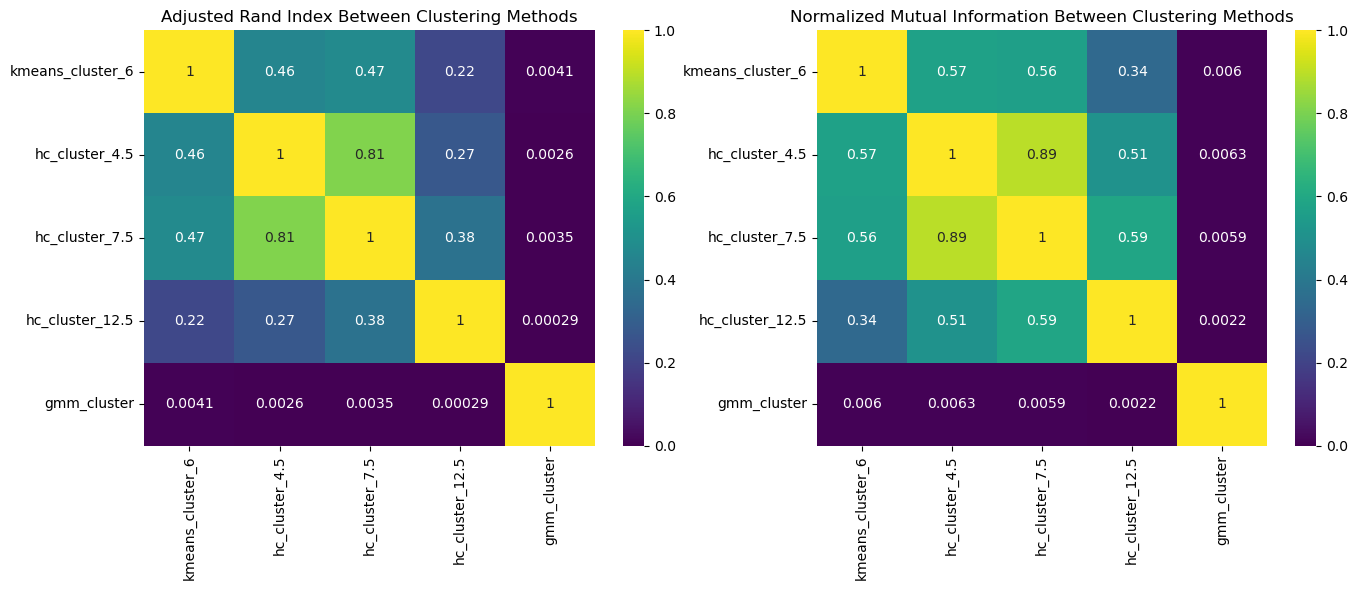


Overall Agreement Score (average agreement with other methods):


,Avg_Rand_Index,Avg_NMI
hc_cluster_7.5,0.332308,0.410331
hc_cluster_4.5,0.307901,0.396009
kmeans_cluster_6,0.230135,0.296024
hc_cluster_12.5,0.172608,0.286937
gmm_cluster,0.002083,0.004078



Most similar clustering pairs (Adjusted Rand Index):
hc_cluster_4.5 - hc_cluster_7.5: 0.8087
kmeans_cluster_6 - hc_cluster_7.5: 0.4738
kmeans_cluster_6 - hc_cluster_4.5: 0.4569


In [117]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns

# Extract unique users with their cluster assignments
user_clusters = user_items_df[['pid', 'kmeans_cluster_6', 'hc_cluster_4.5', 
                              'hc_cluster_7.5', 'hc_cluster_12.5', 'gmm_cluster']].drop_duplicates()

# Check if we actually have one row per user
user_counts = user_clusters.groupby('pid').size()
if user_counts.max() > 1:
    print(f"Warning: {(user_counts > 1).sum()} users have multiple cluster assignments. Taking the most frequent one.")
    # Get the most frequent cluster assignment for each user
    user_clusters = user_items_df.groupby('pid').agg({
        'kmeans_cluster_6': lambda x: x.value_counts().index[0],
        'hc_cluster_4.5': lambda x: x.value_counts().index[0],
        'hc_cluster_7.5': lambda x: x.value_counts().index[0],
        'hc_cluster_12.5': lambda x: x.value_counts().index[0],
        'gmm_cluster': lambda x: x.value_counts().index[0]
    }).reset_index()

print(f"Analyzing cluster agreement for {len(user_clusters)} unique users")

# Get clustering method names
clustering_methods = user_clusters.columns[1:].tolist()

# Calculate pairwise agreement metrics
agreement_rand = np.zeros((len(clustering_methods), len(clustering_methods)))
agreement_nmi = np.zeros((len(clustering_methods), len(clustering_methods)))

for i, method1 in enumerate(clustering_methods):
    for j, method2 in enumerate(clustering_methods):
        if i == j:
            agreement_rand[i, j] = 1.0  # Perfect agreement with self
            agreement_nmi[i, j] = 1.0
        else:
            # Calculate adjusted Rand index
            ari = adjusted_rand_score(user_clusters[method1], user_clusters[method2])
            agreement_rand[i, j] = ari
            
            # Calculate normalized mutual information
            nmi = normalized_mutual_info_score(user_clusters[method1], user_clusters[method2])
            agreement_nmi[i, j] = nmi

# Create DataFrames for better visualization
rand_df = pd.DataFrame(agreement_rand, 
                     index=clustering_methods, 
                     columns=clustering_methods)

nmi_df = pd.DataFrame(agreement_nmi, 
                     index=clustering_methods, 
                     columns=clustering_methods)

# Print the agreement matrices
print("\nAdjusted Rand Index (higher means more agreement):")
display(rand_df)

print("\nNormalized Mutual Information (higher means more agreement):")
display(nmi_df)

# Visualize the agreement matrices
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(rand_df, annot=True, cmap='viridis', vmin=0, vmax=1)
plt.title('Adjusted Rand Index Between Clustering Methods')
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.heatmap(nmi_df, annot=True, cmap='viridis', vmin=0, vmax=1)
plt.title('Normalized Mutual Information Between Clustering Methods')
plt.tight_layout()

plt.savefig('cluster_agreement.png')
plt.show()

# Calculate overall agreement score for each clustering method
rand_mean = rand_df.mean(axis=1) - 0.2  # Subtract self-comparison (1.0)
nmi_mean = nmi_df.mean(axis=1) - 0.2    # Normalize by removing self-comparison

print("\nOverall Agreement Score (average agreement with other methods):")
agreement_df = pd.DataFrame({
    'Avg_Rand_Index': rand_mean,
    'Avg_NMI': nmi_mean
}).sort_values('Avg_NMI', ascending=False)

display(agreement_df)

# Find most similar pairs of clustering methods
rand_values = []
for i in range(len(clustering_methods)):
    for j in range(i+1, len(clustering_methods)):
        rand_values.append((clustering_methods[i], clustering_methods[j], agreement_rand[i, j]))

top_similar = sorted(rand_values, key=lambda x: x[2], reverse=True)
print("\nMost similar clustering pairs (Adjusted Rand Index):")
for method1, method2, score in top_similar[:3]:
    print(f"{method1} - {method2}: {score:.4f}")

In [173]:
# Read cluster_summaries from pickle
with open('food_cluster_summaries.pkl', 'rb') as f:
    cluster_summaries = pickle.load(f)

In [174]:
cluster_summaries

{np.int64(0): {'cluster_id': np.int64(0),
  'num_foods': 38,
  'top_representatives': ['pasta',
   'spaghetti',
   'carbonara',
   'cacio_e_pepe',
   'macaroni'],
  'macro_stats': {'calories': {'mean': np.float64(314.6578947368421),
    'std': np.float64(123.00476591446825),
    'min': np.float64(112.0),
    'max': np.float64(575.0),
    'cv': np.float64(0.3909158739441159)},
   'protein': {'mean': np.float64(10.45921052631579),
    'std': np.float64(4.248291533743733),
    'min': np.float64(2.5),
    'max': np.float64(26.0),
    'cv': np.float64(0.40617707455594876)},
   'fat': {'mean': np.float64(14.368684210526316),
    'std': np.float64(17.421185102453887),
    'min': np.float64(0.16),
    'max': np.float64(55.8),
    'cv': np.float64(1.2124412261556523)},
   'carbohydrates': {'mean': np.float64(36.11342105263159),
    'std': np.float64(27.914745422099223),
    'min': np.float64(5.2),
    'max': np.float64(75.0),
    'cv': np.float64(0.772974274063273)},
   'fiber': {'mean': np.flo

In [175]:
def analyze_macro_profiles_by_user_cluster(user_items_df, cluster_summaries, user_cluster_col='kmeans_cluster_6'):
    """
    Compute average macronutrient profiles for each user cluster based on their food consumption.
    
    Parameters:
    -----------
    user_items_df : pandas DataFrame
        DataFrame containing user food logs with cluster assignments and food clusters
    cluster_summaries : dict
        Dictionary containing nutritional information for each food cluster
    user_cluster_col : str
        Column name for the user clustering method to analyze
        
    Returns:
    --------
    dict
        Dictionary containing macronutrient profiles for each user cluster
    """
    # Convert cluster_summaries keys to integers if needed
    cluster_summaries = {int(k) if not isinstance(k, int) else k: v for k, v in cluster_summaries.items()}
    
    # Get unique user clusters
    user_clusters = user_items_df[user_cluster_col].dropna().unique()
    
    # Initialize results dictionary
    results = {}
    
    # Process each user cluster
    for user_cluster in sorted(user_clusters):
        # Get food entries for users in this cluster
        cluster_entries = user_items_df[user_items_df[user_cluster_col] == user_cluster]
        
        # Count occurrences of each food cluster
        food_cluster_counts = cluster_entries['food_cluster'].value_counts()
        total_entries = food_cluster_counts.sum()
        
        # Initialize nutrient accumulators
        weighted_macros = {
            'calories': 0,
            'protein': 0,
            'fat': 0,
            'carbohydrates': 0,
            'fiber': 0,
            'sugar': 0
        }
        
        # Initialize percentage accumulators
        weighted_pct = {
            'protein': 0,
            'fat': 0,
            'carbohydrates': 0,
            'sugar': 0
        }
        
        # Count foods with valid nutrition data
        valid_food_count = 0
        
        # Process each food cluster consumed by users in this cluster
        for food_cluster, count in food_cluster_counts.items():
            if pd.isna(food_cluster):
                continue
                
            # Convert to int if needed
            food_cluster = int(food_cluster)
                
            # Check if we have nutrition data for this food cluster
            if food_cluster in cluster_summaries:
                food_summary = cluster_summaries[food_cluster]
                
                # Check if we have macro stats
                if 'macro_stats' in food_summary and food_summary['macro_stats']:
                    macro_stats = food_summary['macro_stats']
                    
                    # Calculate weight for this food cluster (proportion of consumption)
                    weight = count / total_entries
                    
                    # Add weighted macronutrient values
                    for nutrient in weighted_macros.keys():
                        if nutrient in macro_stats and macro_stats[nutrient] and 'mean' in macro_stats[nutrient]:
                            weighted_macros[nutrient] += macro_stats[nutrient]['mean'] * weight
                    
                    # Track valid food clusters
                    valid_food_count += count
                
                # Check if we have percentage stats
                if 'pct_stats' in food_summary and food_summary['pct_stats']:
                    pct_stats = food_summary['pct_stats']
                    
                    # Calculate weight for percentage stats
                    weight = count / total_entries
                    
                    # Add weighted percentage values
                    for nutrient in weighted_pct.keys():
                        if nutrient in pct_stats and pct_stats[nutrient] and 'mean' in pct_stats[nutrient]:
                            weighted_pct[nutrient] += pct_stats[nutrient]['mean'] * weight
        
        # Store results for this user cluster
        results[user_cluster] = {
            'macros_per_100g': weighted_macros,
            'macro_percentages': weighted_pct,
            'total_food_entries': total_entries,
            'valid_nutrition_entries': valid_food_count,
            'coverage': valid_food_count / total_entries if total_entries > 0 else 0
        }
    
    # Print summary of findings
    print(f"\nMacronutrient Profiles by User Cluster ({user_cluster_col}):")
    print("=" * 80)
    
    for user_cluster, profile in sorted(results.items()):
        print(f"\nCluster {user_cluster}:")
        print(f"  Nutritional data coverage: {profile['valid_nutrition_entries']}/{profile['total_food_entries']} entries ({profile['coverage']*100:.1f}%)")
        
        print("  Average nutrition per 100g:")
        for nutrient, value in profile['macros_per_100g'].items():
            unit = "g" if nutrient != "calories" else ""
            print(f"    {nutrient}: {value:.1f}{unit}")
        
        print("  Macronutrient ratio (% of calories):")
        for nutrient, value in profile['macro_percentages'].items():
            print(f"    {nutrient}: {value:.1f}%")
    
    return results

# Example usage:
macro_profiles = analyze_macro_profiles_by_user_cluster(user_items_df, cluster_summaries, 'kmeans_cluster_6')


Macronutrient Profiles by User Cluster (kmeans_cluster_6):

Cluster 0:
  Nutritional data coverage: 708515/708515 entries (100.0%)
  Average nutrition per 100g:
    calories: 196.0
    protein: 7.2g
    fat: 10.8g
    carbohydrates: 18.0g
    fiber: 2.3g
    sugar: 6.4g
  Macronutrient ratio (% of calories):
    protein: 18.3%
    fat: 33.8%
    carbohydrates: 48.1%
    sugar: 19.0%

Cluster 1:
  Nutritional data coverage: 542186/542186 entries (100.0%)
  Average nutrition per 100g:
    calories: 194.0
    protein: 7.7g
    fat: 10.4g
    carbohydrates: 17.7g
    fiber: 2.2g
    sugar: 5.8g
  Macronutrient ratio (% of calories):
    protein: 19.1%
    fat: 33.4%
    carbohydrates: 47.0%
    sugar: 17.7%

Cluster 2:
  Nutritional data coverage: 689969/689969 entries (100.0%)
  Average nutrition per 100g:
    calories: 196.2
    protein: 7.0g
    fat: 10.9g
    carbohydrates: 18.2g
    fiber: 2.4g
    sugar: 6.6g
  Macronutrient ratio (% of calories):
    protein: 18.1%
    fat: 33.6%
 